## Eval results of the model

This notebook has the stats of the model evaluated against a couple of baselines: the MBMP threshold model and the CH4Net model of [Vaughan et al 2024](https://amt.copernicus.org/articles/17/2583/2024/). We reproduce in this notebook the plot of Figure 2, the histograms of Figure 3 and the histograms of Figure S4. In addition in this notebook we have the statistics that are mentioned in the text (precision, recall, average precision, false positive rates...)

In [1]:
%%time
import matplotlib
from marss2l.utils import setup_stream_logger, get_remote_filesystem, pathjoin
from marss2l import loaders
import logging
import os

import uuid
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import PrecisionRecallDisplay, precision_score, recall_score, accuracy_score,\
    average_precision_score, confusion_matrix
from sklearn.metrics import RocCurveDisplay, roc_curve
import numpy as np
from marss2l.plot import C0, C1, C2, C3
import seaborn as sns
import json

logger = logging.getLogger(__name__)
setup_stream_logger(logger)


fs = get_remote_filesystem()
os.makedirs("figures", exist_ok=True)

Using account key
CPU times: user 9.26 s, sys: 2.25 s, total: 11.5 s
Wall time: 7.27 s


In [2]:
csv_path = "az://public/MARS-S2L/dataset_20250609/validated_images_all.csv" 

dataframe_data_traintest = loaders.read_csv(csv_path,
                                            add_columns_for_analysis=True, fs=fs, 
                                            split="all", 
                                            add_case_study=True, add_loc_type=True)
dataframe_data_traintest.shape
# 92269, 58
# (86316, 58)
# 93581

(93581, 59)

In [3]:
# Sanity check: fluxrate is positive and defined always
dataframe_data_traintest.loc[(dataframe_data_traintest.ch4_fluxrate < 0) | dataframe_data_traintest.ch4_fluxrate.isna(),["location_name","satellite","tile_date","observability","isplume","ch4_fluxrate","country","wind_speed"]]

,location_name,satellite,tile_date,observability,isplume,ch4_fluxrate,country,wind_speed


In [4]:
# Sanity check: fluxrate is zero for no plumes
dataframe_data_traintest[~dataframe_data_traintest.isplume].ch4_fluxrate.sum()

0.0

In [5]:
# Sanity check: All isplume have positive flux rates
dataframe_data_traintest[dataframe_data_traintest.isplume & (dataframe_data_traintest.ch4_fluxrate == 0)]

,id_loc_image,s2path,plumepath,cloudmaskpath,ch4path,location_name_short,wind_u,wind_v,wind_speed,vza,...,year_month_day,isplumeneg,date,satellite_constellation,year_quarter,ch4_fluxrate_th,interval_ch4_fluxrate,interval_ch4_fluxrate_str,loc_type,case_study
70815,d3836b80-0e88-4c4f-afb5-83c20686d7c1,az://public/MARS-S2L/dataset_20250609/model_da...,az://public/MARS-S2L/dataset_20250609/model_da...,az://public/MARS-S2L/dataset_20250609/model_da...,az://public/MARS-S2L/dataset_20250609/model_da...,Standfordcontrolledreleases,4.765106,2.98333,5.621965,0.017296,...,2022-11-03,False,2022-11-03,Landsat,2022-4Q,0.0,"(-0.001001, 0.0]","[0, 0]",no samples,United States of America


## Load CSV files with evaluation results

In the next cell we load the evaluation results. These results are loaded from the pre-computed CSV files in the `basefolder_experiments` path. If you re-evaluated the model following the instructions in the `README.md`, change the `basefolder_experiments` to your local path.


In [6]:
from marss2l.validation_utils import load_stats_and_config
pd.options.display.float_format = "{:,.2f}".format

basefolder_experiments = "az://public/MARS-S2L/train_logs_revision/"


outs = []
ids_all = None


expload = [
          ("CH4Netsim_20250605", "CH4Net (sim)", "preds_test_2023thr100"),
          ("MARSS2Lnosim_20250605", "MARS-S2L (no sim)", "preds_test_2023thr100"),
          ("MARSS2L_20250326", "MARS-S2L", "preds_test_2023th100"),
          ("MARSS2L_off_20250523", "MARS-S2L (offshore)", "preds_test_2023thr100"),
          ("CH4Net_20250329","CH4Net", "preds_test_2023thr100"),
          ("MBMP","MBMP", "preds_test_2023th100"),
]

config_experiments = dict()
for  train_folder, model_name, csv_file in  expload:
    output, config = load_stats_and_config(train_folder, model_name, csv_file=csv_file,
                                          basefolder_experiments=basefolder_experiments,fs=fs,
                                           logger=logger)
    if config is not None:
        config_experiments[model_name] = config
    
    ids_iter = set(output["id_loc_image"].values)
    if ids_all is None:
        ids_all = ids_iter
    else:
        ids_all = ids_all.intersection(ids_iter)
    outs.append(output)
print(f"There are {len(ids_all)} common ids")

outs = pd.concat(outs, ignore_index=True)
outs = outs[outs.id_loc_image.isin(ids_all)].copy()

outs.groupby(["model_name","target"])[["id_loc_image"]].count()

/home/gonzalo/mambaforge/envs/marss2lpy312/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-06-24 10:59:57,776 - __main__ - INFO - Loading eval results from az://public/MARS-S2L/train_logs_revision/CH4Netsim_20250605/preds_test_2023thr100.csv
2025-06-24 11:00:08,120 - __main__ - INFO - Loading config from az://public/MARS-S2L/train_logs_revision/CH4Netsim_20250605/config_experiment.json
2025-06-24 11:00:08,702 - __main__ - INFO - Loading eval results from az://public/MARS-S2L/train_logs_revision/MARSS2Lnosim_20250605/preds_test_2023thr100.csv
2025-06-24 11:00:17,288 - __main__ - INFO - Loading config from az://public/MARS-S2L/train_logs_revision/MARSS2Lnosim_20250605/config_experiment.json
2025-06-24 11:00:17,882 - __main__ - INFO - Loading eval results from az://public/MARS-S2L/train_logs_revision/

There are 43529 common ids


id_loc_image
model_name          target              
CH4Net              0              41716
                    1               1813
CH4Net (sim)        0              41716
                    1               1813
MARS-S2L            0              41716
                    1               1813
MARS-S2L (no sim)   0              41716
                    1               1813
MARS-S2L (offshore) 0              41716
                    1               1813
MBMP                0              41716
                    1               1813

In [7]:
threshold_mbmp = -.99
threshold_marss2l = 0.5
outs_merge = outs.drop(["location_name", "tile"], axis=1)
outs_same_period_with_fluxrate = pd.merge(outs_merge, dataframe_data_traintest[dataframe_data_traintest.split_name == "test_2023"], 
                                          on ="id_loc_image")
outs_same_period_with_fluxrate = outs_same_period_with_fluxrate.drop("target", axis=1) # Use isplume as GT from dataframe_data_traintest
outs_same_period_with_fluxrate["isplumenum"] = outs_same_period_with_fluxrate["isplume"].astype(int)
# outs_same_period_with_fluxrate["isplumeprednum"] = (outs_same_period_with_fluxrate["scene_pred"] > 0.5).astype(int)
outs_same_period_with_fluxrate["isplumeprednum"] = outs_same_period_with_fluxrate.apply(lambda row: row.scene_pred > threshold_mbmp if row.model_name.startswith("MBMP") else row.scene_pred > threshold_marss2l, axis=1).astype(int)
outs_same_period_with_fluxrate["scenepredcontinuous"] = outs_same_period_with_fluxrate["scene_pred"]
outs_same_period_with_fluxrate.id_loc_image.nunique()

43529

#### Combine offshore and onshore predictions for MARS-S2L model

In [8]:
marss2l_onshore = outs_same_period_with_fluxrate[((outs_same_period_with_fluxrate.model_name == "MARS-S2L") & ~outs_same_period_with_fluxrate.offshore)].copy()
marss2l_onshore["model_name"] = "MARS-S2L (combined)"
marss2l_offshore = outs_same_period_with_fluxrate[((outs_same_period_with_fluxrate.model_name == "MARS-S2L (offshore)") & outs_same_period_with_fluxrate.offshore)].copy()
marss2l_offshore["model_name"] = "MARS-S2L (combined)"
outs_same_period_with_fluxrate = pd.concat([outs_same_period_with_fluxrate, marss2l_onshore, marss2l_offshore], ignore_index=True)
outs_same_period_with_fluxrate.id_loc_image.nunique()

# Rename MARS-S2L combined and drop offshore
outs_same_period_with_fluxrate = outs_same_period_with_fluxrate[~outs_same_period_with_fluxrate.model_name.isin(["MARS-S2L (offshore)", "MARS-S2L"])].copy()
outs_same_period_with_fluxrate.loc[outs_same_period_with_fluxrate.model_name == "MARS-S2L (combined)","model_name"] = "MARS-S2L"

In [9]:
outs_same_period_with_fluxrate.groupby(["model_name","isplume"])[["id_loc_image"]].count()

id_loc_image
model_name        isplume              
CH4Net            False           41716
                  True             1813
CH4Net (sim)      False           41716
                  True             1813
MARS-S2L          False           41716
                  True             1813
MARS-S2L (no sim) False           41716
                  True             1813
MBMP              False           41716
                  True             1813

In [10]:
# Sanity check: all models are evaluated in the same number of images
outs_same_period_with_fluxrate.groupby("model_name")["tile_date"].agg(["min", "max", "count"])

,min,max,count
model_name,,,
CH4Net,2024-01-01 00:05:22.713000+00:00,2024-12-31 17:27:23.051000+00:00,43529
CH4Net (sim),2024-01-01 00:05:22.713000+00:00,2024-12-31 17:27:23.051000+00:00,43529
MARS-S2L,2024-01-01 00:05:22.713000+00:00,2024-12-31 17:27:23.051000+00:00,43529
MARS-S2L (no sim),2024-01-01 00:05:22.713000+00:00,2024-12-31 17:27:23.051000+00:00,43529
MBMP,2024-01-01 00:05:22.713000+00:00,2024-12-31 17:27:23.051000+00:00,43529


In [11]:
# Sanity check: all models are evaluated in the same number of images and same number of plumes/noplumes
outs_same_period_with_fluxrate.groupby(["isplume","model_name"])[["id_loc_image"]].count()

id_loc_image
isplume model_name                     
False   CH4Net                    41716
        CH4Net (sim)              41716
        MARS-S2L                  41716
        MARS-S2L (no sim)         41716
        MBMP                      41716
True    CH4Net                     1813
        CH4Net (sim)               1813
        MARS-S2L                   1813
        MARS-S2L (no sim)          1813
        MBMP                       1813

In [12]:
outs_same_period_with_fluxrate.model_name.unique()

array(['CH4Net (sim)', 'MARS-S2L (no sim)', 'CH4Net', 'MBMP', 'MARS-S2L'],
      dtype=object)

## PR curves and general metrics

### Overall metrics

Final model is `MARS-S2L (U326v309)`

In [13]:
from marss2l.metrics import get_scenelevel_metrics, get_pixellevel_metrics


mets = []
for idx_threshold, (threshold_marss2l_iter, threshold_mbmp_iter) in enumerate(zip([0.5, 0.9, 0.98],[threshold_mbmp, -0.9, -0.85])):
    for model in ['MARS-S2L', 'MARS-S2L (no sim)','CH4Net (sim)', 'CH4Net', "MBMP"]:
        dg = outs_same_period_with_fluxrate[outs_same_period_with_fluxrate.model_name == model]
        threshold = threshold_marss2l_iter if not model.startswith("MBMP") else threshold_mbmp_iter
        mets_iter = get_scenelevel_metrics(dg.scenepredcontinuous, dg.isplumenum, threshold=threshold,
                                           as_percentage=True)
        mets_seg = get_pixellevel_metrics(TP=dg.TP, TN=dg.TN, FP=dg.FP, FN=dg.FN,
                                         as_percentage=True)
        mets_iter.update(mets_seg)
        
        mets_iter.update({"nsamples": dg.shape[0],
                     "nlocs": dg.location_name.nunique(),
                     "nplumes": dg.isplumenum.sum(),
                     "threshold": threshold,
                          "idx_threshold": idx_threshold,
                     "nnoplume": (1-dg.isplumenum).sum(),
                     "model_name": model})
        mets.append(mets_iter)

mets = pd.DataFrame(mets)# .sort_values(["balanced_accuracy"], ascending=False)
overall_mets = mets[["model_name", "threshold"]+[c for c in mets.columns if c not in ["model_name", "threshold"]]].copy()
overall_mets

,model_name,threshold,average_precision,precision,recall,accuracy,binary_cross_entropy,fpr,balanced_accuracy,segmentation_precision,segmentation_recall,segmentation_accuracy,segmentation_f1,segmentation_fpr,iou,nsamples,nlocs,nplumes,idx_threshold,nnoplume
0,MARS-S2L,0.50,64.08,32.53,79.15,92.29,0.23,7.13,86.01,39.93,62.60,99.78,48.76,0.16,32.24,43529,1289,1813,0,41716
1,MARS-S2L (no sim),0.50,53.61,45.28,60.62,95.31,0.19,3.18,78.72,54.12,43.67,99.85,48.34,0.06,31.87,43529,1289,1813,0,41716
2,CH4Net (sim),0.50,29.72,16.23,48.98,87.34,0.36,10.99,68.99,21.99,27.28,99.72,24.35,0.16,13.86,43529,1289,1813,0,41716
3,CH4Net,0.50,21.20,16.44,46.94,87.86,0.34,10.37,68.29,15.93,23.12,99.67,18.86,0.20,10.41,43529,1289,1813,0,41716
4,MBMP,-0.99,4.22,4.74,78.87,33.11,1.50,68.88,55.00,0.26,3.21,97.84,0.49,2.00,0.24,43529,1289,1813,0,41716
5,MARS-S2L,0.90,64.08,52.61,69.39,96.12,0.23,2.72,83.34,39.93,62.60,99.78,48.76,0.16,32.24,43529,1289,1813,1,41716
6,MARS-S2L (no sim),0.90,53.61,60.03,50.36,96.54,0.19,1.46,74.45,54.12,43.67,99.85,48.34,0.06,31.87,43529,1289,1813,1,41716
7,CH4Net (sim),0.90,29.72,29.84,36.02,93.81,0.36,3.68,66.17,21.99,27.28,99.72,24.35,0.16,13.86,43529,1289,1813,1,41716
8,CH4Net,0.90,21.20,29.14,27.74,94.18,0.34,2.93,62.41,15.93,23.12,99.67,18.86,0.20,10.41,43529,1289,1813,1,41716
9,MBMP,-0.90,4.22,2.81,9.10,83.10,1.50,13.69,47.71,0.26,3.21,97.84,0.49,2.00,0.24,43529,1289,1813,1,41716


In [14]:
cols_metrics = ['model_name', 'average_precision', 'precision', 'recall', 'accuracy',
        'fpr']
cols_metrics_segmentation = ['segmentation_precision', 'segmentation_recall',
       'segmentation_accuracy', 'segmentation_fpr', 'iou']

In [15]:
models_plot_recall = ["MBMP", "CH4Net", "MARS-S2L"]
overall_mets_table_7 = overall_mets[(overall_mets.idx_threshold == 0) & overall_mets.model_name.isin(models_plot_recall)].copy()
print(overall_mets_table_7[cols_metrics+cols_metrics_segmentation].to_latex(index=False,float_format="%.2f"))

\begin{tabular}{lrrrrrrrrrr}
\toprule
model_name & average_precision & precision & recall & accuracy & fpr & segmentation_precision & segmentation_recall & segmentation_accuracy & segmentation_fpr & iou \\
\midrule
MARS-S2L & 64.08 & 32.53 & 79.15 & 92.29 & 7.13 & 39.93 & 62.60 & 99.78 & 0.16 & 32.24 \\
CH4Net & 21.20 & 16.44 & 46.94 & 87.86 & 10.37 & 15.93 & 23.12 & 99.67 & 0.20 & 10.41 \\
MBMP & 4.22 & 4.74 & 78.87 & 33.11 & 68.88 & 0.26 & 3.21 & 97.84 & 2.00 & 0.24 \\
\bottomrule
\end{tabular}



In [16]:
overall_mets_table_7[cols_metrics+cols_metrics_segmentation]

,model_name,average_precision,precision,recall,accuracy,fpr,segmentation_precision,segmentation_recall,segmentation_accuracy,segmentation_fpr,iou
0,MARS-S2L,64.08,32.53,79.15,92.29,7.13,39.93,62.60,99.78,0.16,32.24
3,CH4Net,21.20,16.44,46.94,87.86,10.37,15.93,23.12,99.67,0.20,10.41
4,MBMP,4.22,4.74,78.87,33.11,68.88,0.26,3.21,97.84,2.00,0.24


In [17]:
models_plot_recall = ["MBMP", "CH4Net", "MARS-S2L"]
col_metrics_table = ["model_name","threshold","precision", "recall", "fpr"]
overall_mets_table_thresholds = overall_mets.loc[overall_mets.model_name.isin(models_plot_recall)]
print(overall_mets_table_thresholds[col_metrics_table].to_latex(index=False,float_format="%.2f"))

\begin{tabular}{lrrrr}
\toprule
model_name & threshold & precision & recall & fpr \\
\midrule
MARS-S2L & 0.50 & 32.53 & 79.15 & 7.13 \\
CH4Net & 0.50 & 16.44 & 46.94 & 10.37 \\
MBMP & -0.99 & 4.74 & 78.87 & 68.88 \\
MARS-S2L & 0.90 & 52.61 & 69.39 & 2.72 \\
CH4Net & 0.90 & 29.14 & 27.74 & 2.93 \\
MBMP & -0.90 & 2.81 & 9.10 & 13.69 \\
MARS-S2L & 0.98 & 68.68 & 58.91 & 1.17 \\
CH4Net & 0.98 & 41.15 & 16.55 & 1.03 \\
MBMP & -0.85 & 2.66 & 4.63 & 7.37 \\
\bottomrule
\end{tabular}



In [18]:
overall_mets_table_thresholds[col_metrics_table]

,model_name,threshold,precision,recall,fpr
0,MARS-S2L,0.50,32.53,79.15,7.13
3,CH4Net,0.50,16.44,46.94,10.37
4,MBMP,-0.99,4.74,78.87,68.88
5,MARS-S2L,0.90,52.61,69.39,2.72
8,CH4Net,0.90,29.14,27.74,2.93
9,MBMP,-0.90,2.81,9.10,13.69
10,MARS-S2L,0.98,68.68,58.91,1.17
13,CH4Net,0.98,41.15,16.55,1.03
14,MBMP,-0.85,2.66,4.63,7.37


In [19]:
col_metrics_table

['model_name', 'threshold', 'precision', 'recall', 'fpr']

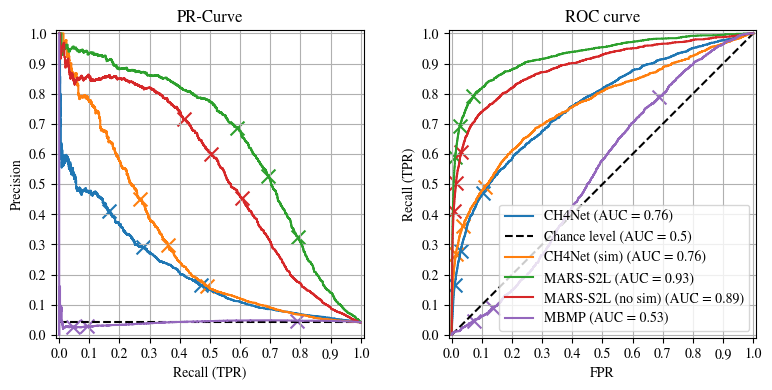

In [20]:
fig, ax = plt.subplots(1,2,figsize=(8, 4),tight_layout=True, sharey=False)
iaxes_roc = 1
iaxes_pr = 0
overall_mets_indexed = overall_mets.set_index("model_name")
models_plot_prcurve = ["MBMP", "CH4Net", "MARS-S2L", "MARS-S2L (no sim)", "CH4Net (sim)"] # "MARS-S2L (no sim)", "CH4Net (sim)"
df_show = outs_same_period_with_fluxrate[outs_same_period_with_fluxrate.model_name.isin(models_plot_prcurve)].copy()
for _i_prev, (model_name, out_same_period) in enumerate(df_show.groupby("model_name")):
    dg = out_same_period
    display = PrecisionRecallDisplay.from_predictions(dg.isplumenum, dg.scenepredcontinuous,
                                                      plot_chance_level=_i_prev == 0,
                                                      ax=ax[iaxes_pr], name=model_name)
    
    display = RocCurveDisplay.from_predictions(dg.isplumenum, dg.scenepredcontinuous,
                                               plot_chance_level=_i_prev == 0,
                                                ax=ax[iaxes_roc], name=model_name)
    ax[0].scatter([overall_mets_indexed.loc[model_name, "recall"]/100], 
                  [overall_mets_indexed.loc[model_name, "precision"]/100],
                  s=100,
                  marker="x")
    ax[1].scatter([overall_mets_indexed.loc[model_name, "fpr"]/100],
                  [overall_mets_indexed.loc[model_name, "recall"]/100], 
                  s=100,
                  marker="x")
    
# ax[iaxes_pr].legend(loc="upper right")
ax[iaxes_pr].get_legend().remove()
ax[iaxes_roc].grid()
ax[iaxes_pr].grid()
ax[iaxes_pr].set_xticks(np.arange(0,1.05,.1))
ax[iaxes_pr].set_yticks(np.arange(0,1.05,.1))
ax[iaxes_pr].set_title("PR-Curve")
ax[iaxes_roc].set_title("ROC curve")
ax[iaxes_roc].set_xticks(np.arange(0,1.05,.1))
ax[iaxes_roc].set_xlabel("FPR")
ax[iaxes_roc].set_ylabel("Recall (TPR)")
ax[iaxes_pr].set_ylabel("Precision")
ax[iaxes_pr].set_xlabel("Recall (TPR)")
_ = ax[iaxes_roc].set_yticks(np.arange(0,1.05,.1))
plt.savefig("figures/pr_and_roc_curves.pdf")

### Compute metrics stratified by type of location

There are two types of locs:
1. Locs that were used for training.
1. Locs that were not used for training.

In [21]:
model_ref = "MARS-S2L"
locs_train = set(config_experiments[model_ref]['all_locs_train'])
locs_film = set()
# if "id zero" in model_ref:
#     locs_film = set()
# else:
#     locs_film = set([k for k,v in config_experiments[model_ref]["film_dict_mapping"].items() if v > 0])

print(len(locs_train), len(locs_film))
outs_same_period_with_fluxrate["loc_type_train"] = outs_same_period_with_fluxrate.location_name.apply(lambda x: "FiLM" if x in locs_film else "some samples" if x in locs_train else "no samples")

aggs_sanity = outs_same_period_with_fluxrate.groupby("loc_type_train")["location_name"].agg(["nunique"])
aggs_sanity["nimages"] = outs_same_period_with_fluxrate.groupby("loc_type_train")["id_loc_image"].nunique()
# aggs_sanity["nplumes"] = outs_same_period_with_fluxrate.groupby("loc_type_train")["isplumenum"].sum()
aggs_sanity.rename(columns={"nunique":"nlocs"})

618 0


,nlocs,nimages
loc_type_train,,
no samples,697,15655
some samples,592,27874


In [22]:
# Sanity check
aggs_sanity = outs_same_period_with_fluxrate.groupby("loc_type_train")["location_name"].agg(["nunique"])
aggs_sanity["nimages"] = outs_same_period_with_fluxrate.groupby("loc_type_train")["id_loc_image"].nunique()
aggs_sanity["nplumes"] = outs_same_period_with_fluxrate[outs_same_period_with_fluxrate.model_name == model_ref].groupby("loc_type_train")["isplumenum"].sum()
aggs_sanity.rename(columns={"nunique":"nlocs"})

,nlocs,nimages,nplumes
loc_type_train,,,
no samples,697,15655,227
some samples,592,27874,1586


In [23]:
from itertools import product

mets = []
for (model, loc_type), dg in outs_same_period_with_fluxrate.groupby(["model_name","loc_type_train"]):
    threshold = threshold_marss2l if not model.startswith("MBMP") else threshold_mbmp
    mets_iter = get_scenelevel_metrics(dg.scenepredcontinuous, dg.isplumenum, as_percentage=True,threshold=threshold)
    mets_seg = get_pixellevel_metrics(TP=dg.TP, TN=dg.TN, FP=dg.FP, FN=dg.FN, as_percentage=True)
    mets_iter.update(mets_seg)
    mets_iter.update({"nsamples": dg.shape[0],
                 "nlocs": dg.location_name.nunique(),
                 "nplumes": dg.isplumenum.sum(),
                 "nnoplume": (1-dg.isplumenum).sum(),
                 "loc_type": loc_type,
                 "model_name": model})
    mets.append(mets_iter)
    

mets = pd.DataFrame(mets).sort_values(["loc_type","balanced_accuracy"], ascending=False)
overall_mets_strat_type_of_loc = mets[["model_name"]+[c for c in mets.columns if c != "model_name"]].copy()

In [24]:
models_show_by_type_of_loc = ["MBMP", "CH4Net", "MARS-S2L", "MARS-S2L (no sim)", "CH4Net (sim)"]
overall_mets_strat_type_of_loc.loc[overall_mets_strat_type_of_loc.model_name.isin(models_show_by_type_of_loc),
                                   ['loc_type'] + cols_metrics].set_index("loc_type")

,model_name,average_precision,precision,recall,accuracy,fpr
loc_type,,,,,,
some samples,MARS-S2L,68.82,41.17,79.38,92.37,6.84
some samples,MARS-S2L (no sim),60.76,55.20,62.61,94.98,3.07
some samples,CH4Net (sim),38.86,23.71,52.90,87.63,10.27
some samples,CH4Net,31.59,23.50,51.51,87.70,10.11
some samples,MBMP,5.70,6.37,80.26,31.72,71.21
no samples,MARS-S2L,44.96,13.01,77.53,92.16,7.63
no samples,MARS-S2L (no sim),27.25,16.88,46.70,95.89,3.38
no samples,CH4Net (sim),3.28,2.53,21.59,86.82,12.22
no samples,MBMP,1.38,1.54,69.16,35.58,64.91


In [25]:
print(overall_mets_strat_type_of_loc.loc[overall_mets_strat_type_of_loc.model_name.isin(models_show_by_type_of_loc),
                                   ['loc_type'] + cols_metrics].set_index("loc_type").to_latex(float_format="%.2f"))

\begin{tabular}{llrrrrr}
\toprule
 & model_name & average_precision & precision & recall & accuracy & fpr \\
loc_type &  &  &  &  &  &  \\
\midrule
some samples & MARS-S2L & 68.82 & 41.17 & 79.38 & 92.37 & 6.84 \\
some samples & MARS-S2L (no sim) & 60.76 & 55.20 & 62.61 & 94.98 & 3.07 \\
some samples & CH4Net (sim) & 38.86 & 23.71 & 52.90 & 87.63 & 10.27 \\
some samples & CH4Net & 31.59 & 23.50 & 51.51 & 87.70 & 10.11 \\
some samples & MBMP & 5.70 & 6.37 & 80.26 & 31.72 & 71.21 \\
no samples & MARS-S2L & 44.96 & 13.01 & 77.53 & 92.16 & 7.63 \\
no samples & MARS-S2L (no sim) & 27.25 & 16.88 & 46.70 & 95.89 & 3.38 \\
no samples & CH4Net (sim) & 3.28 & 2.53 & 21.59 & 86.82 & 12.22 \\
no samples & MBMP & 1.38 & 1.54 & 69.16 & 35.58 & 64.91 \\
no samples & CH4Net & 2.19 & 2.00 & 14.98 & 88.13 & 10.79 \\
\bottomrule
\end{tabular}



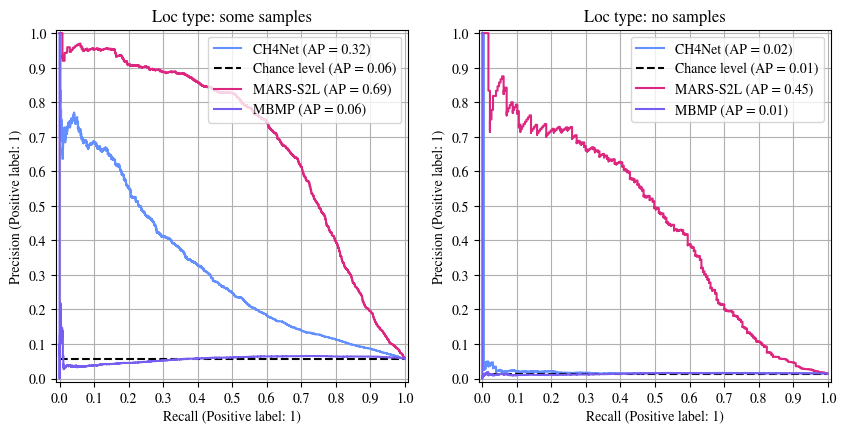

In [26]:
# locs_type = ["few samples", "no samples", "FiLM"]
locs_type = ["some samples", "no samples"]
fig, ax = plt.subplots(1, len(locs_type),figsize=(len(locs_type) * 5, 5))


colors = [C0, C2, C2, C1, C1]

models_show = ["MBMP", "CH4Net", "MARS-S2L"]
for i, loc_type_show in enumerate(locs_type):
    outs_same_period_with_fluxrate_loc = outs_same_period_with_fluxrate[outs_same_period_with_fluxrate.loc_type_train == loc_type_show]
    for _i_prev, (model_name, out_same_period) in enumerate(outs_same_period_with_fluxrate_loc.groupby("model_name")):
        if model_name not in models_show:
            continue
        
        display = PrecisionRecallDisplay.from_predictions(out_same_period.isplumenum, out_same_period.scenepredcontinuous,
                                                          plot_chance_level=_i_prev == 0,c=colors[_i_prev],
                                                          ax=ax[i], name=model_name)
    
    
    ax[i].set_title(f"Loc type: {loc_type_show}")
    ax[i].set_xticks(np.arange(0,1.05,.1))
    ax[i].set_yticks(np.arange(0,1.05,.1))
    ax[i].legend(loc="upper right")
    ax[i].grid()

## Metrics plumes by flux rate

In [27]:
# Sanity check interval of plumes
outs_same_period_with_fluxrate.groupby(["isplume","interval_ch4_fluxrate_str"])[["id_loc_image"]].nunique()

/tmp/ipykernel_33313/151046986.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  outs_same_period_with_fluxrate.groupby(["isplume","interval_ch4_fluxrate_str"])[["id_loc_image"]].nunique()


id_loc_image
isplume interval_ch4_fluxrate_str              
False   [0, 0]                            41716
        (0, 0.5]                              0
        (0.5, 1]                              0
        (1, 1.5]                              0
        (1.5, 2]                              0
        (2, 2.5]                              0
        (2.5, 3]                              0
        (3, 4]                                0
        (4, 5]                                0
        (5, 6]                                0
        (6, 7]                                0
        (7, 8]                                0
        (8, 9]                                0
        (9, 10]                               0
        (10, 15]                              0
        (15, 20]                              0
        >20                                   0
True    [0, 0]                                0
        (0, 0.5]                             11
        (0.5, 1]                             78
        (1, 1.5]                            147
        (1.5, 2]                            144
        (2, 2.5]                            176
        (2.5, 3]                            157
        (3, 4]                              223
        (4, 5]                              161
        (5, 6]                              112
        (6, 7]                               92
        (7, 8]                               81
        (8, 9]                               53
        (9, 10]                              53
        (10, 15]                            151
        (15, 20]                             94
        >20                                  80

## Fig prob vs emission rate

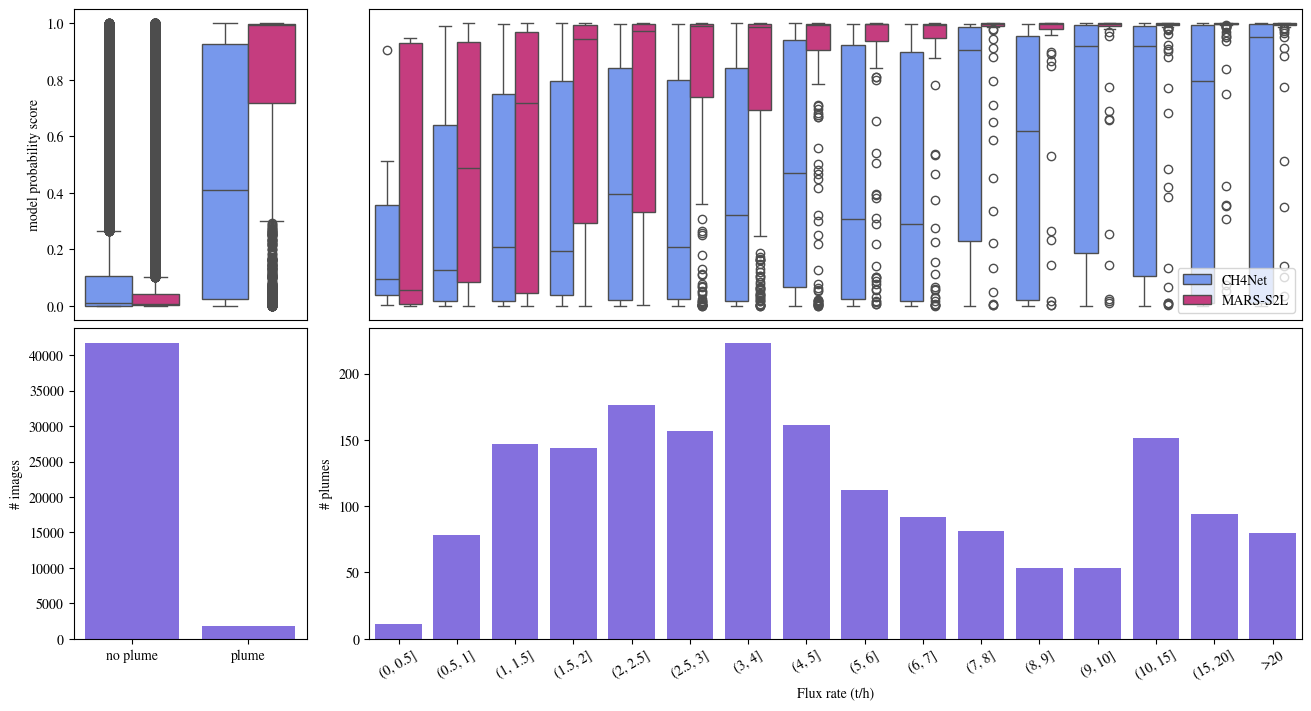

In [28]:
from marss2l import plot
# from importlib import reload
# reload(plot)

model_names_plot = ["CH4Net", "MARS-S2L"] # "CH4Net",
df_plot = outs_same_period_with_fluxrate.loc[outs_same_period_with_fluxrate.model_name.isin(model_names_plot)]
fig, ax = plot.plot_prob_vs_emission_rate(df_plot)

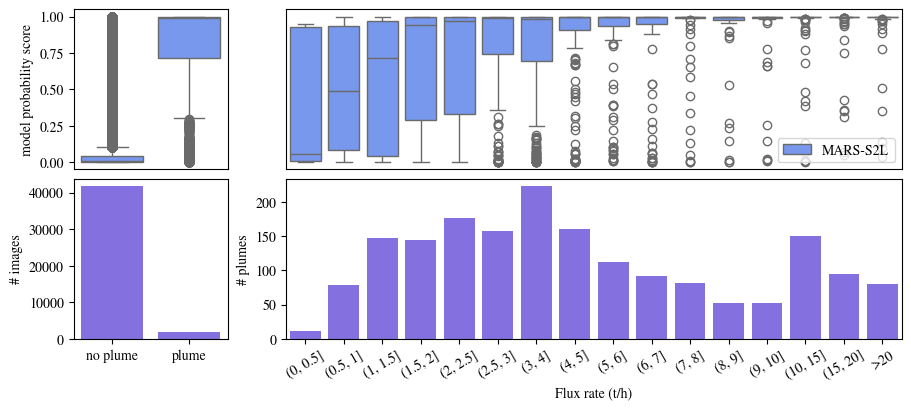

In [29]:
from marss2l import plot
from marss2l.plot import prob_vs_emission_rate
from importlib import reload
# reload(plot)
reload(prob_vs_emission_rate)

model_names_plot = ["MARS-S2L"] # "CH4Net",
df_plot = outs_same_period_with_fluxrate.loc[outs_same_period_with_fluxrate.model_name.isin(model_names_plot)]
fig, ax = prob_vs_emission_rate.plot_prob_vs_emission_rate(df_plot, figsize=(9,4))

## Recall vs Fluxrate

<Figure size 1000x300 with 0 Axes>

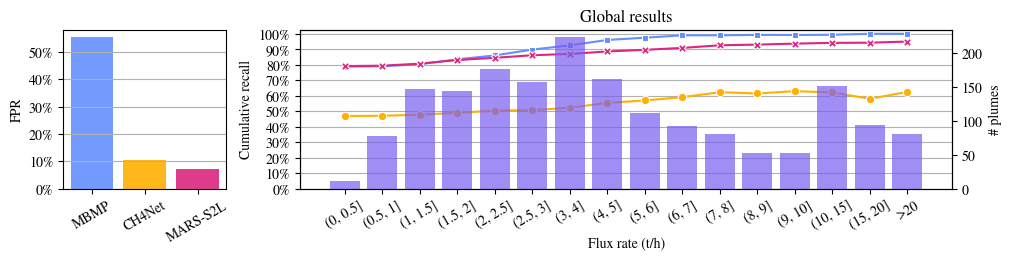

In [30]:
from marss2l.plot import recall_fluxrate_plot
from marss2l.plot import plot_recall_fpr_fluxrate

import numpy as np

from importlib import reload

reload(recall_fluxrate_plot)
models_plot_recall = ["MBMP", "CH4Net", "MARS-S2L"]

plt.figure(figsize=(10,3), layout="constrained")
fig, axs = recall_fluxrate_plot.plot_recall_fpr_fluxrate(outs_same_period_with_fluxrate, order_models=models_plot_recall,
                                                        loc_legend="center right", add_legend=False)

axs[1].set_title("Global results")
axs[0].set_yticks(np.arange(0,.55,.10))
# axs[1].set_yticks(np.arange(.5,.95,.1).tolist() + np.arange(.95,1.04,.05).tolist())

plt.savefig("figures/fig2_overall.pdf")

#### Non-cummulative

<Figure size 1000x300 with 0 Axes>

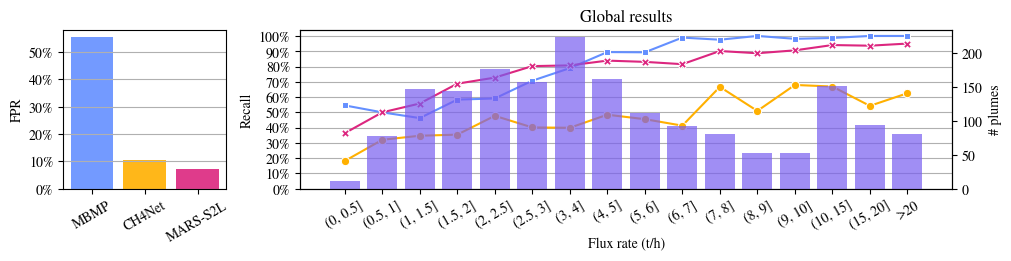

In [31]:
plt.figure(figsize=(10,3), layout="constrained")
fig, axs = recall_fluxrate_plot.plot_recall_fpr_fluxrate(outs_same_period_with_fluxrate, order_models=models_plot_recall,
                                                        loc_legend="center right", add_legend=False,
                                                         cummulative=False)

axs[1].set_title("Global results")
axs[0].set_yticks(np.arange(0,.55,.10))
# axs[1].set_yticks(np.arange(.5,.95,.1).tolist() + np.arange(.95,1.04,.05).tolist())

plt.savefig("figures/fig2_overall_noncum.pdf")

## Results in case studies

In [32]:
pd.options.display.max_rows = 200
mets = []
for (model, case_study), dg in outs_same_period_with_fluxrate.groupby(["model_name","case_study"]): 
    # if case_study not in countries:
    #     continue

    # if "(id zero)" in model:
    #     continue
    
    n_locs_few_samples = dg[dg.loc_type_train == "some samples"].location_name.nunique()
    n_locs_no_samples = dg[dg.loc_type_train == "no samples"].location_name.nunique()
    # n_locs_film = dg[dg.loc_type == "FiLM"].location_name.nunique()
    threshold = threshold_marss2l if not model.startswith("MBMP") else threshold_mbmp
    mets_iter = get_scenelevel_metrics(dg.scenepredcontinuous, dg.isplumenum, as_percentage=True,threshold=threshold)
    
    mets_seg = get_pixellevel_metrics(TP=dg.TP, TN=dg.TN, FP=dg.FP, FN=dg.FN, as_percentage=True)
    mets_iter.update(mets_seg)
    
    mets_iter.update({
        "case_study": case_study,
        "model_name": model,
        "nimages": dg.shape[0],
        "nlocs": dg.location_name.nunique(),
        "nplumes": dg.isplumenum.sum(),
        "nlocs samples train": n_locs_few_samples,
        "nlocs no samples at train time": n_locs_no_samples,
        # "nlocs FiLM": n_locs_film,
        "nnoplume": (1-dg.isplumenum).sum()})
    mets.append(mets_iter)

mets = pd.DataFrame(mets).sort_values(["case_study","model_name"])
mets_case_studies = mets[['case_study', 'model_name', 'precision', 'recall', 'fpr',"balanced_accuracy",
       'average_precision', 'nimages','nplumes', # 'nlocs FiLM'
       'nnoplume', 'nlocs',
       'nlocs samples train', 'nlocs no samples at train time']].sort_values(["nimages","balanced_accuracy"], ascending=False).copy()

mets_case_studies

/home/gonzalo/mambaforge/envs/marss2lpy312/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/gonzalo/git/marss2l/marss2l/metrics.py:79: RuntimeWarning: invalid value encountered in scalar divide
  f1 = 2 * precision * recall / (precision + recall)
/home/gonzalo/git/marss2l/marss2l/metrics.py:79: RuntimeWarning: invalid value encountered in scalar divide
  f1 = 2 * precision * recall / (precision + recall)
/home/gonzalo/git/marss2l/marss2l/metrics.py:79: RuntimeWarning: invalid value encountered in scalar divide
  f1 = 2 * precision * recall / (precision + recall)
/home/gonzalo/git/marss2l/marss2l/metrics.py:79: RuntimeWarning: invalid value encountered in scalar divide
  f1 = 2 * precision * recall / (precision + recall)
/home/gonzalo/g

,case_study,model_name,precision,recall,fpr,balanced_accuracy,average_precision,nimages,nplumes,nnoplume,nlocs,nlocs samples train,nlocs no samples at train time
35,Turkmenistan,MARS-S2L,50.00,80.66,8.09,86.28,75.52,9361,853,8508,129,115,14
48,Turkmenistan,MARS-S2L (no sim),63.42,67.88,3.93,81.98,70.49,9361,853,8508,129,115,14
22,Turkmenistan,CH4Net (sim),28.52,64.13,16.11,74.01,51.09,9361,853,8508,129,115,14
9,Turkmenistan,CH4Net,26.32,63.54,17.83,72.86,40.86,9361,853,8508,129,115,14
61,Turkmenistan,MBMP,11.65,81.83,62.20,59.81,10.75,9361,853,8508,129,115,14
36,United States of America,MARS-S2L,26.91,85.42,4.21,90.60,74.67,8083,144,7939,306,230,76
49,United States of America,MARS-S2L (no sim),48.67,50.69,0.97,74.86,49.01,8083,144,7939,306,230,76
62,United States of America,MBMP,2.07,100.00,85.72,57.14,2.11,8083,144,7939,306,230,76
23,United States of America,CH4Net (sim),8.55,13.89,2.70,55.60,9.53,8083,144,7939,306,230,76
10,United States of America,CH4Net,6.67,8.33,2.12,53.11,3.54,8083,144,7939,306,230,76


In [33]:
print(mets_case_studies.loc[mets_case_studies.model_name != "MARS-S2L (first submission)",
      ['case_study','model_name', 'average_precision', 'precision', 'recall', "fpr"]].to_latex(index=False,float_format="%.2f"))

\begin{tabular}{llrrrr}
\toprule
case_study & model_name & average_precision & precision & recall & fpr \\
\midrule
Turkmenistan & MARS-S2L & 75.52 & 50.00 & 80.66 & 8.09 \\
Turkmenistan & MARS-S2L (no sim) & 70.49 & 63.42 & 67.88 & 3.93 \\
Turkmenistan & CH4Net (sim) & 51.09 & 28.52 & 64.13 & 16.11 \\
Turkmenistan & CH4Net & 40.86 & 26.32 & 63.54 & 17.83 \\
Turkmenistan & MBMP & 10.75 & 11.65 & 81.83 & 62.20 \\
United States of America & MARS-S2L & 74.67 & 26.91 & 85.42 & 4.21 \\
United States of America & MARS-S2L (no sim) & 49.01 & 48.67 & 50.69 & 0.97 \\
United States of America & MBMP & 2.11 & 2.07 & 100.00 & 85.72 \\
United States of America & CH4Net (sim) & 9.53 & 8.55 & 13.89 & 2.70 \\
United States of America & CH4Net & 3.54 & 6.67 & 8.33 & 2.12 \\
Libya & MARS-S2L & 31.24 & 12.56 & 68.60 & 9.10 \\
Libya & MARS-S2L (no sim) & 23.77 & 16.08 & 56.20 & 5.59 \\
Libya & CH4Net (sim) & 12.24 & 5.40 & 47.93 & 16.01 \\
Libya & MBMP & 3.79 & 2.95 & 78.51 & 49.16 \\
Libya & CH4Net & 3.5

## Fig 2. Results by case study

/home/gonzalo/mambaforge/envs/marss2lpy312/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


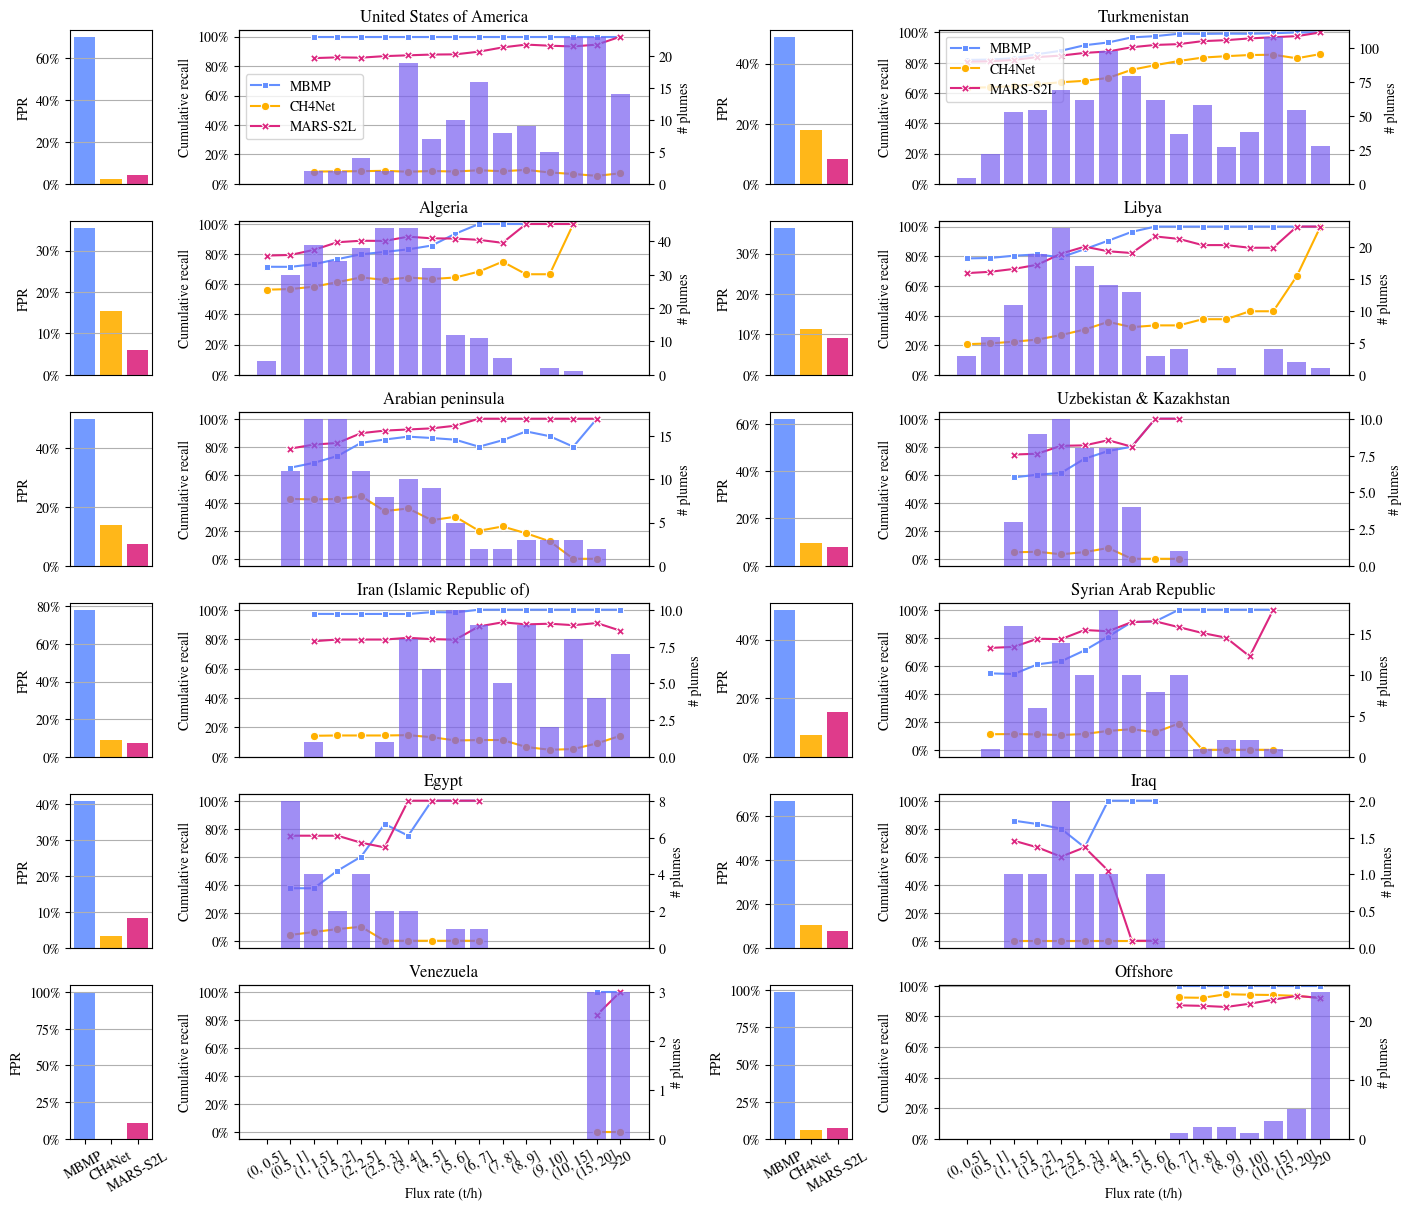

In [34]:
import matplotlib.gridspec as gridspec

case_studies = loaders.ORDER_CASE_STUDIES[:-1]
fig = plt.figure(figsize=(14, 2 * 6), layout="constrained")  # Wider figure to accommodate 4 columns
gs = gridspec.GridSpec(6, 4, width_ratios=[1, 5, 1, 5], figure=fig)

# models_plot_recall = ["MBMP", "CH4Net", "MARS-S2L"]
model_names_plot = models_plot_recall


# Initialize arrays to track shared axes for each column
ax1_col1, ax_col1 = None, None  # For left side (columns 0-1)
ax1_col2, ax_col2 = None, None  # For right side (columns 2-3)

for i, case_study in enumerate(case_studies[::2] + case_studies[1::2]):
    # Calculate position in the grid
    row = i % 6  # Rows 0-5
    col_offset = (i // 6) * 2  # 0 for first 6 case studies, 2 for next 6
    
    # Get the appropriate shared axes based on which side we're plotting
    if col_offset == 0:  # Left side
        ax1 = fig.add_subplot(gs[row, col_offset], sharex=ax1_col1)
        ax = fig.add_subplot(gs[row, col_offset + 1], sharex=ax_col1)
        # Update shared axes references for left side
        if ax1_col1 is None:
            ax1_col1, ax_col1 = ax1, ax
    else:  # Right side
        ax1 = fig.add_subplot(gs[row, col_offset], sharex=ax1_col2)
        ax = fig.add_subplot(gs[row, col_offset + 1], sharex=ax_col2)
        # Update shared axes references for right side
        if ax1_col2 is None:
            ax1_col2, ax_col2 = ax1, ax
    
    # Plot the data
    df_plot = outs_same_period_with_fluxrate[outs_same_period_with_fluxrate.case_study == case_study]
    loc_legend = "center left" if i == 0 else "upper left"
    fig, axs = recall_fluxrate_plot.plot_recall_fpr_fluxrate(
        df_plot, 
        order_models=model_names_plot,
        loc_legend=loc_legend,
        yticks_recall=np.arange(0,1.1, 0.2),
        add_legend=(i == 0) or (i == 6),  # Only add legend for the first two plots
        fig=fig, 
        axs=(ax1, ax)
    )
    axs[1].set_title(case_study)

    if i != 5 and i != 11:
        axs[0].xaxis.set_visible(False)
        axs[1].xaxis.set_visible(False)

plt.savefig("figures/fig2_case_studies_new.pdf")

####  Non-cummulative

/home/gonzalo/mambaforge/envs/marss2lpy312/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


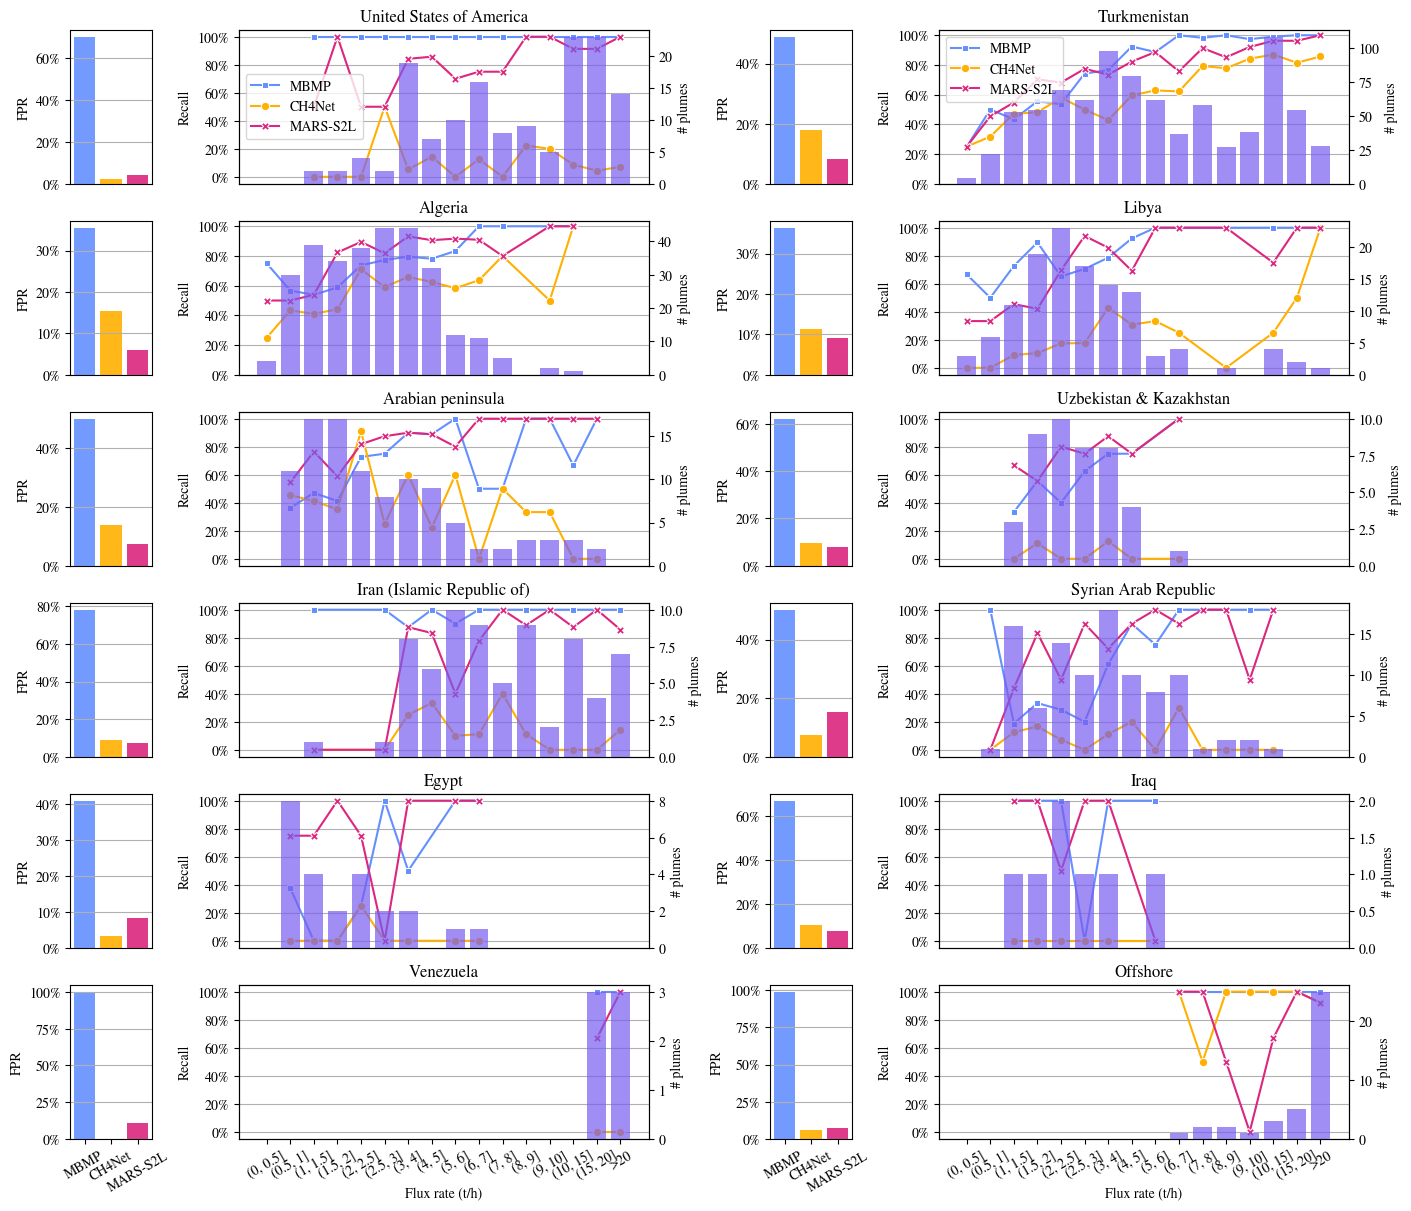

In [35]:
import matplotlib.gridspec as gridspec

case_studies = loaders.ORDER_CASE_STUDIES[:-1]
fig = plt.figure(figsize=(14, 2 * 6), layout="constrained")  # Wider figure to accommodate 4 columns
gs = gridspec.GridSpec(6, 4, width_ratios=[1, 5, 1, 5], figure=fig)

# models_plot_recall = ["MBMP", "CH4Net", "MARS-S2L"]
model_names_plot = models_plot_recall


# Initialize arrays to track shared axes for each column
ax1_col1, ax_col1 = None, None  # For left side (columns 0-1)
ax1_col2, ax_col2 = None, None  # For right side (columns 2-3)

for i, case_study in enumerate(case_studies[::2] + case_studies[1::2]):
    # Calculate position in the grid
    row = i % 6  # Rows 0-5
    col_offset = (i // 6) * 2  # 0 for first 6 case studies, 2 for next 6
    
    # Get the appropriate shared axes based on which side we're plotting
    if col_offset == 0:  # Left side
        ax1 = fig.add_subplot(gs[row, col_offset], sharex=ax1_col1)
        ax = fig.add_subplot(gs[row, col_offset + 1], sharex=ax_col1)
        # Update shared axes references for left side
        if ax1_col1 is None:
            ax1_col1, ax_col1 = ax1, ax
    else:  # Right side
        ax1 = fig.add_subplot(gs[row, col_offset], sharex=ax1_col2)
        ax = fig.add_subplot(gs[row, col_offset + 1], sharex=ax_col2)
        # Update shared axes references for right side
        if ax1_col2 is None:
            ax1_col2, ax_col2 = ax1, ax
    
    # Plot the data
    df_plot = outs_same_period_with_fluxrate[outs_same_period_with_fluxrate.case_study == case_study]
    loc_legend = "center left" if i == 0 else "upper left"
    fig, axs = recall_fluxrate_plot.plot_recall_fpr_fluxrate(
        df_plot, 
        order_models=model_names_plot,
        loc_legend=loc_legend,
        yticks_recall=np.arange(0,1.1, 0.2),
        cummulative=False,
        add_legend=(i == 0) or (i == 6),  # Only add legend for the first two plots
        fig=fig, 
        axs=(ax1, ax)
    )
    axs[1].set_title(case_study)

    if i != 5 and i != 11:
        axs[0].xaxis.set_visible(False)
        axs[1].xaxis.set_visible(False)

plt.savefig("figures/fig2_case_studies_new_noncummulative.pdf")

## Prob. vs fluxrate case studies

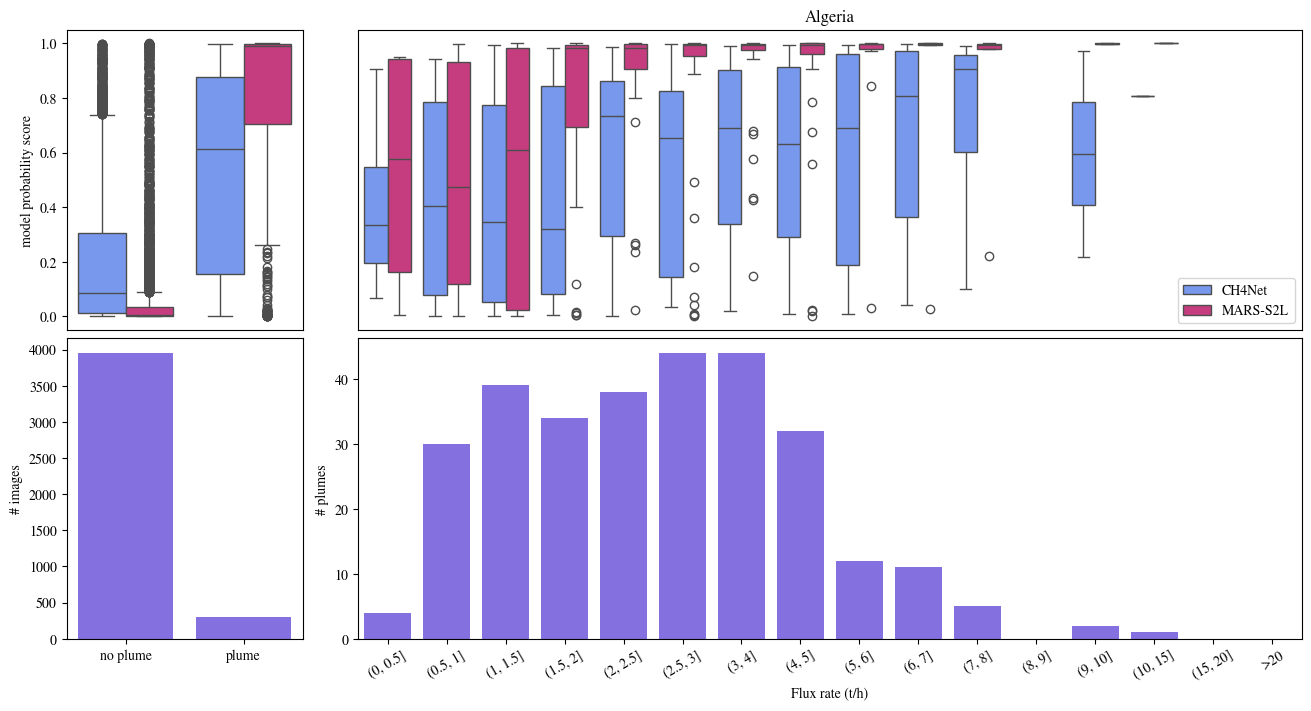

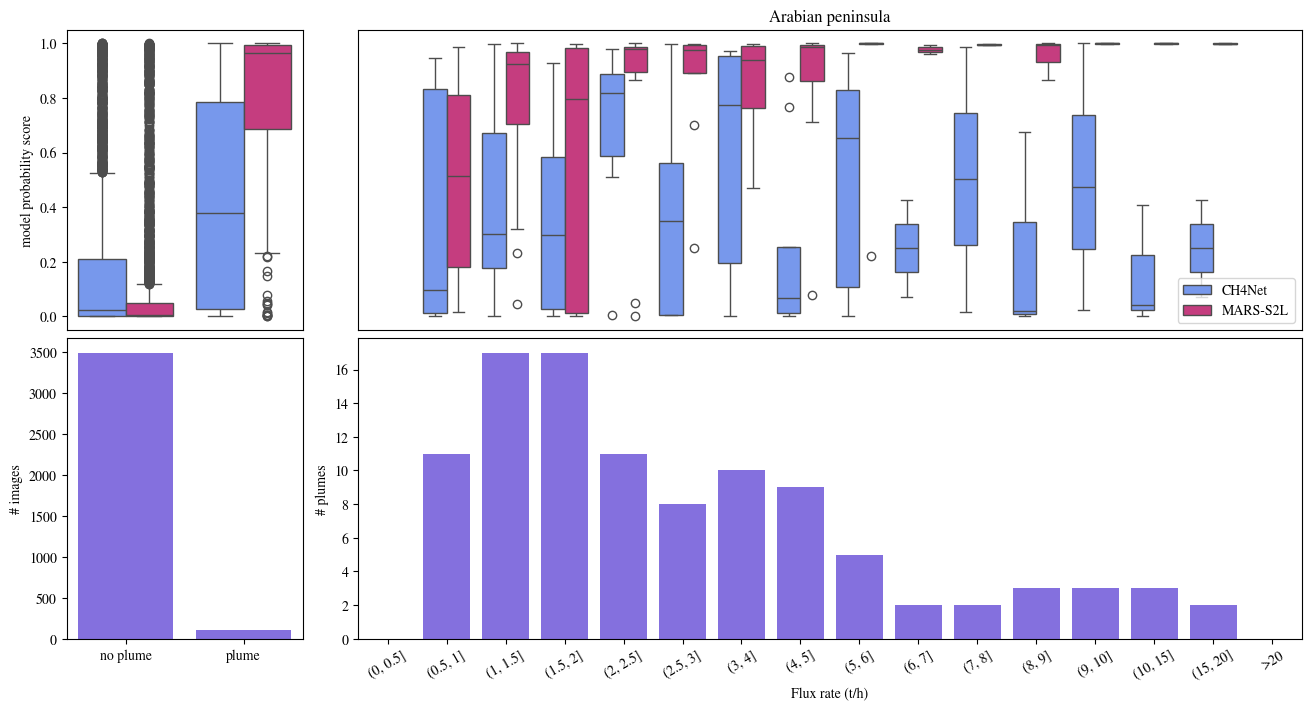

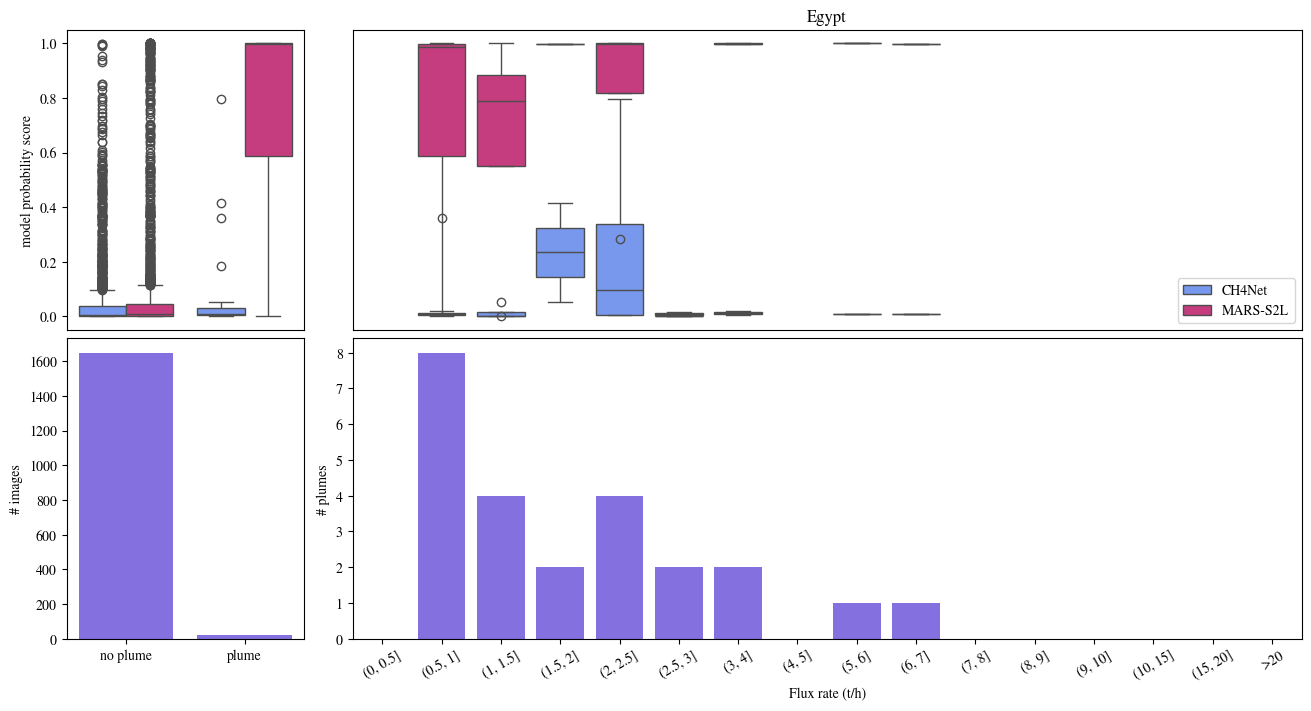

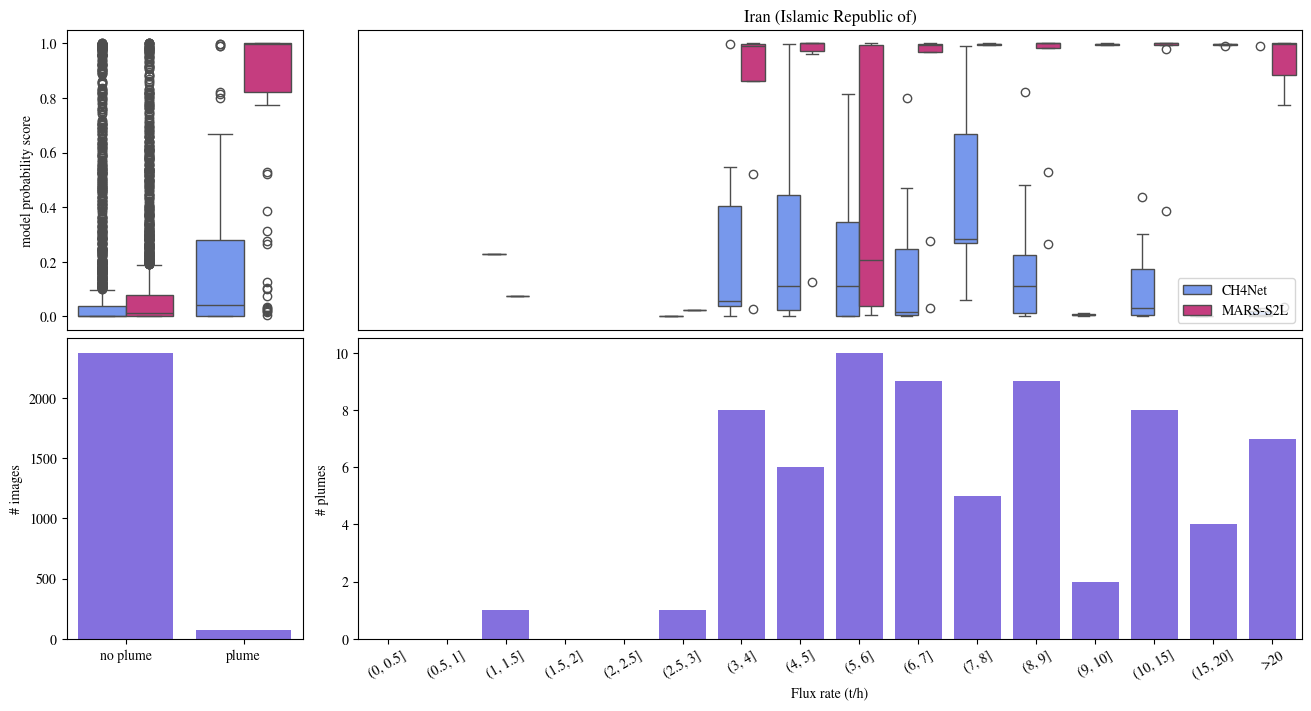

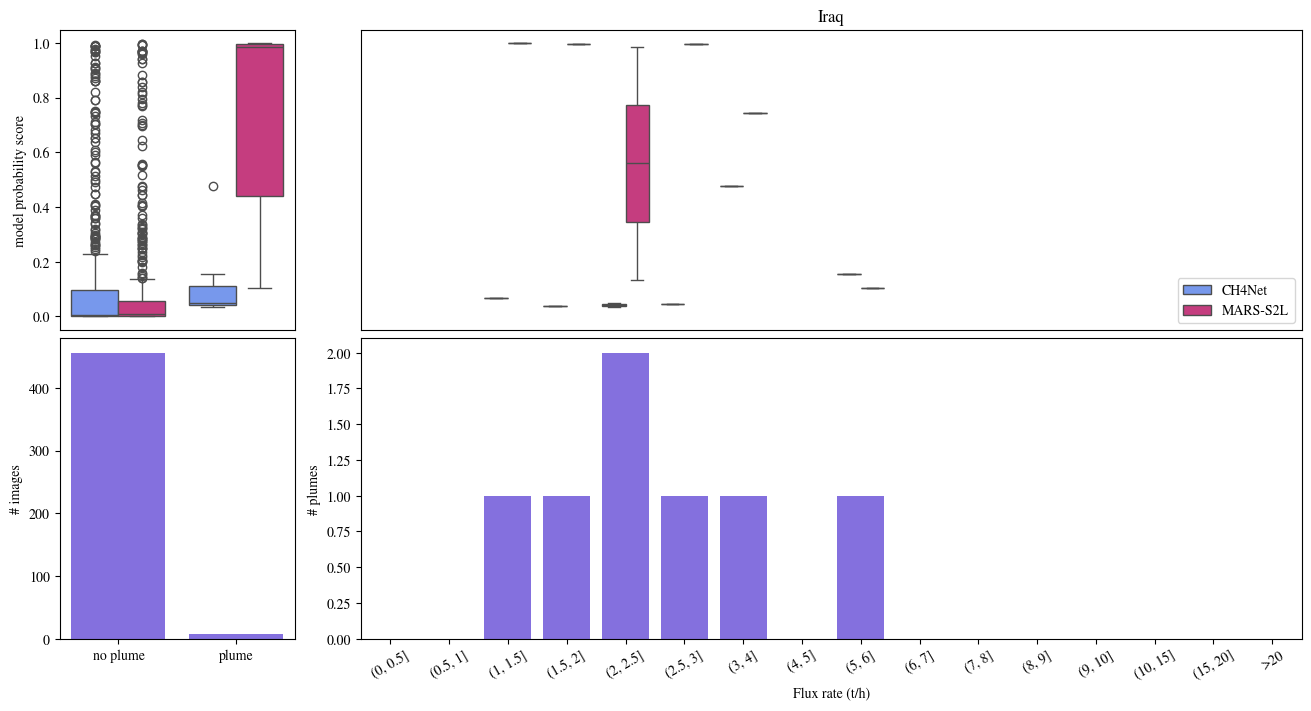

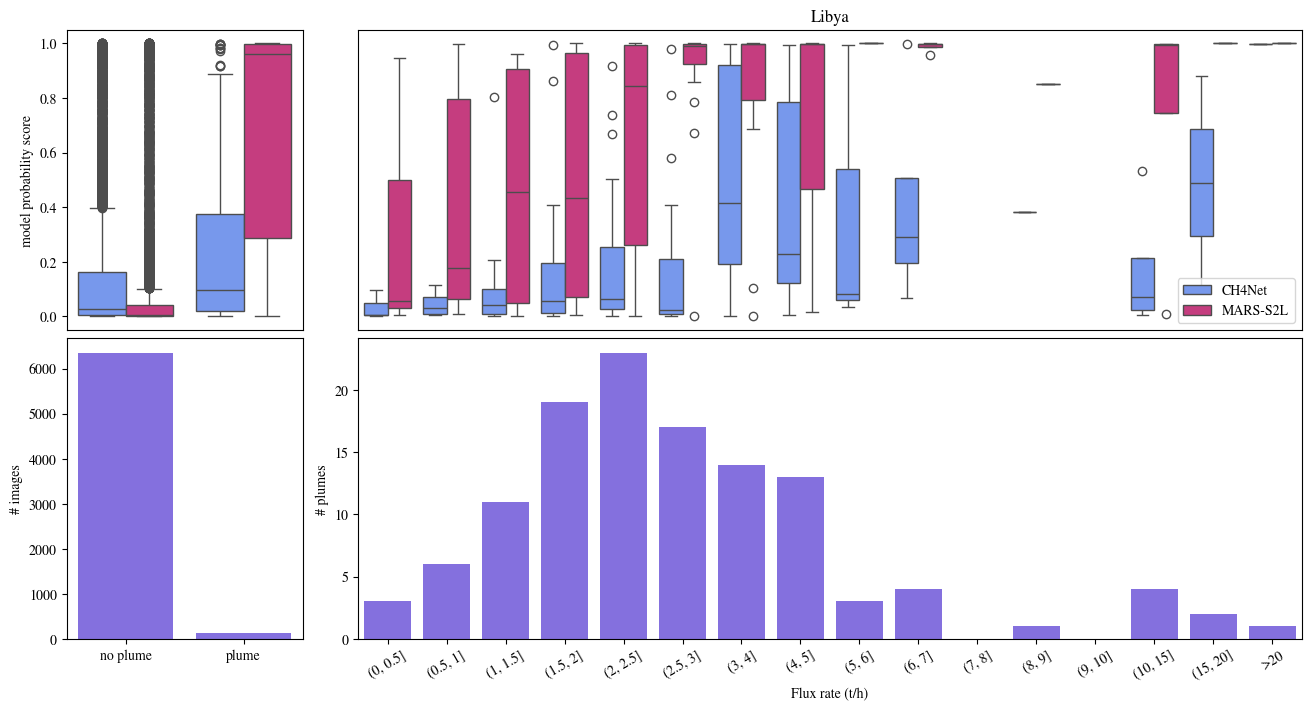

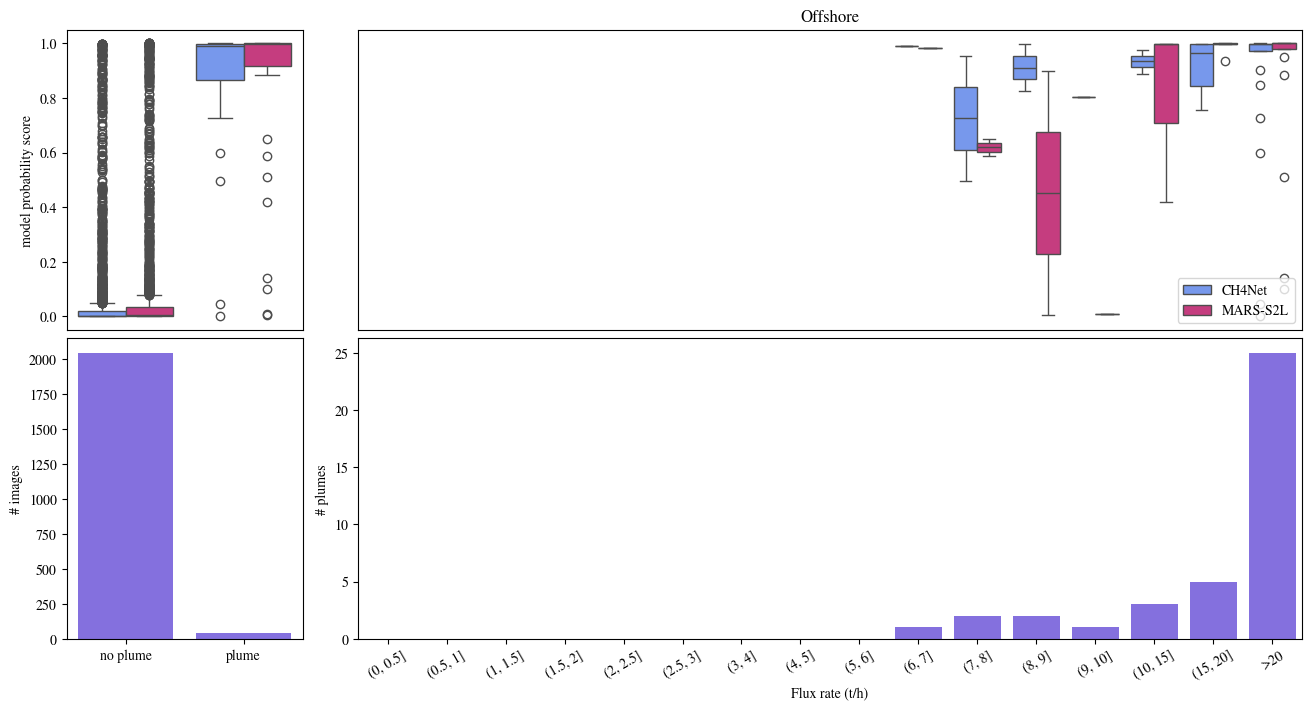

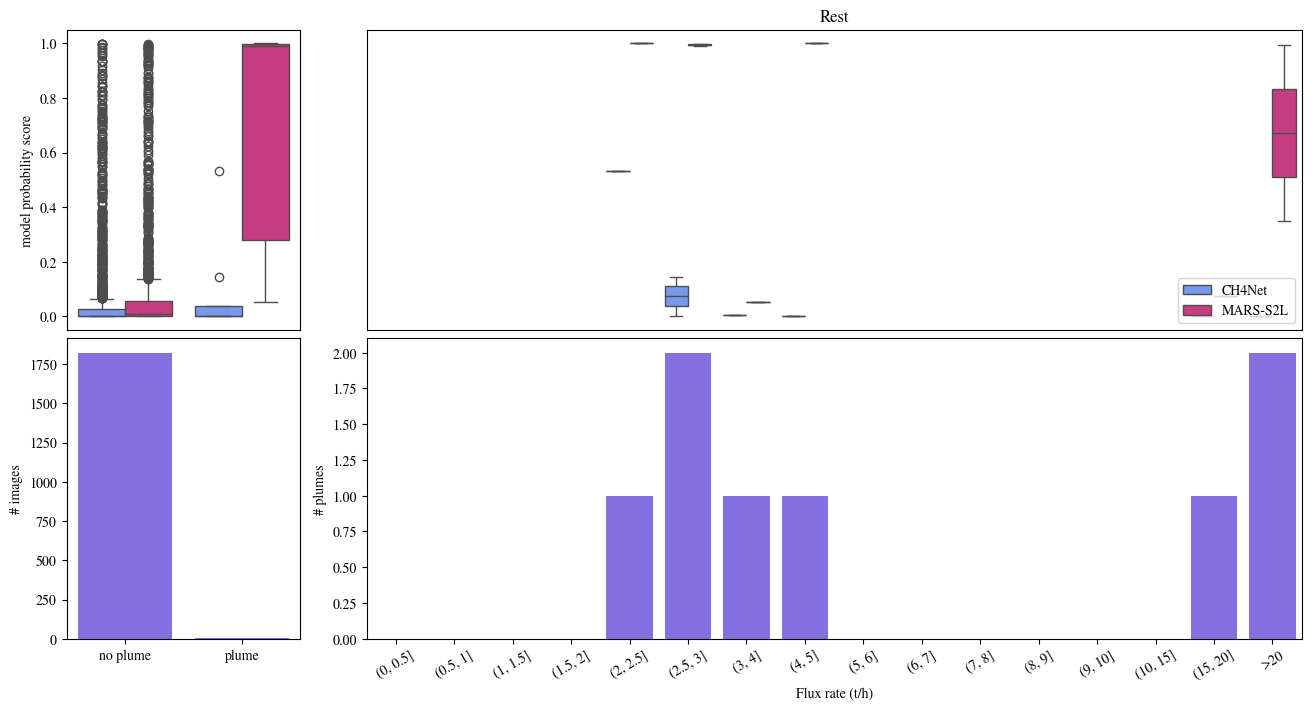

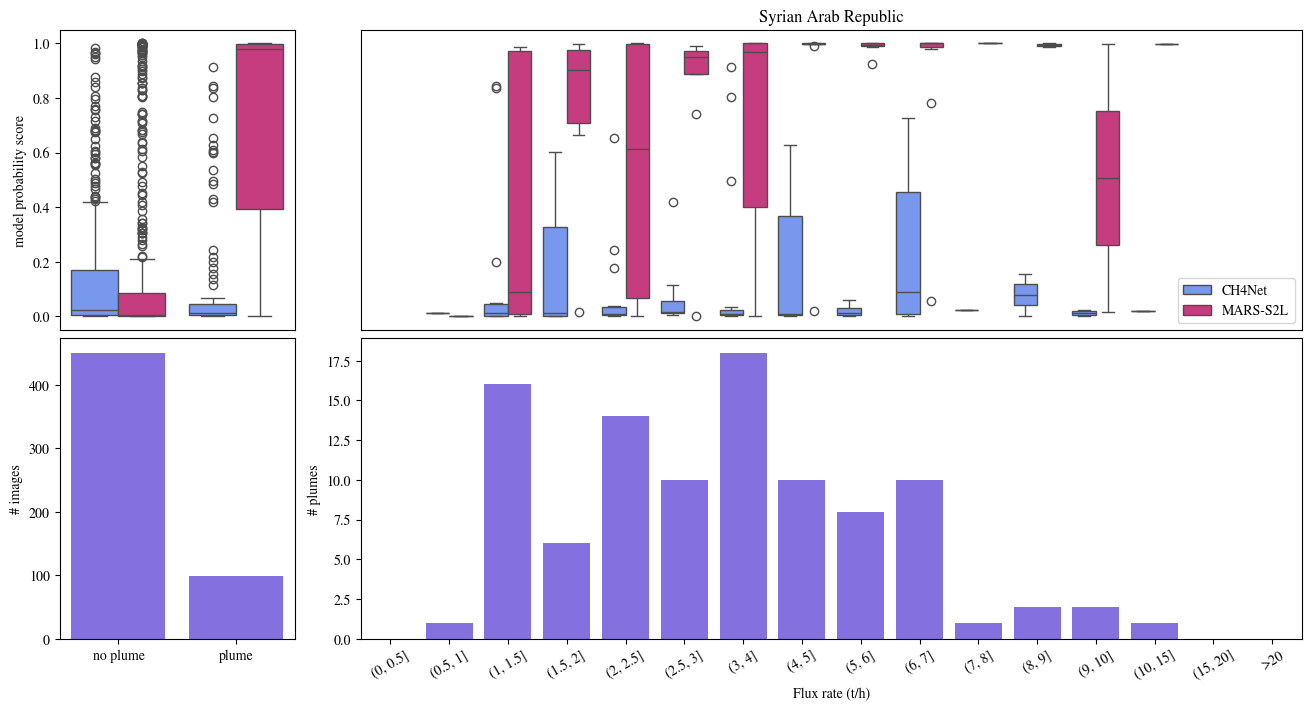

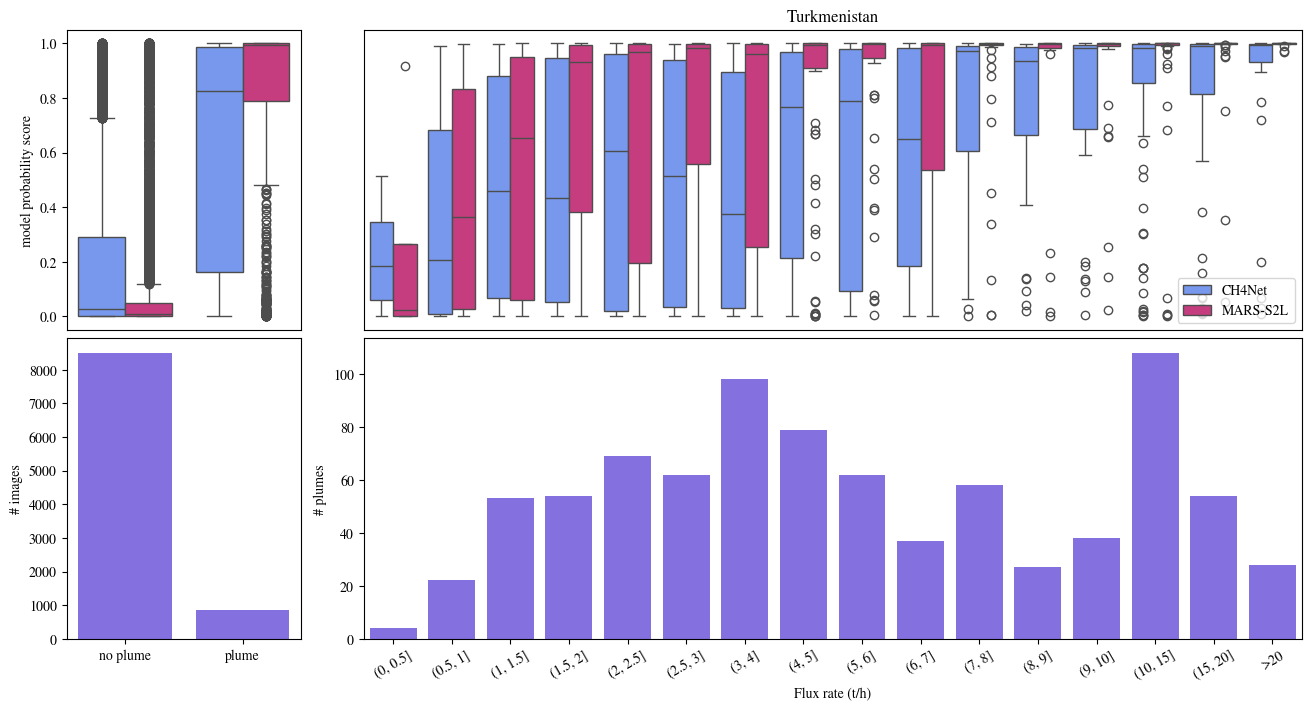

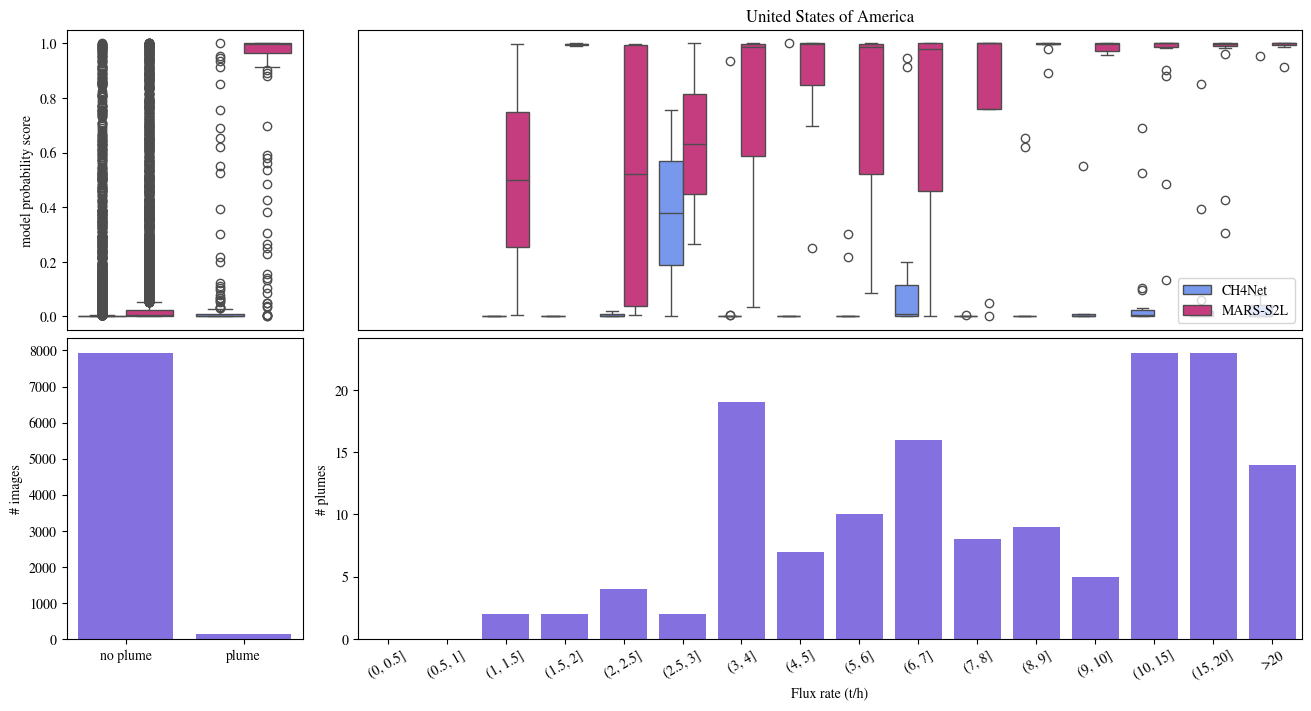

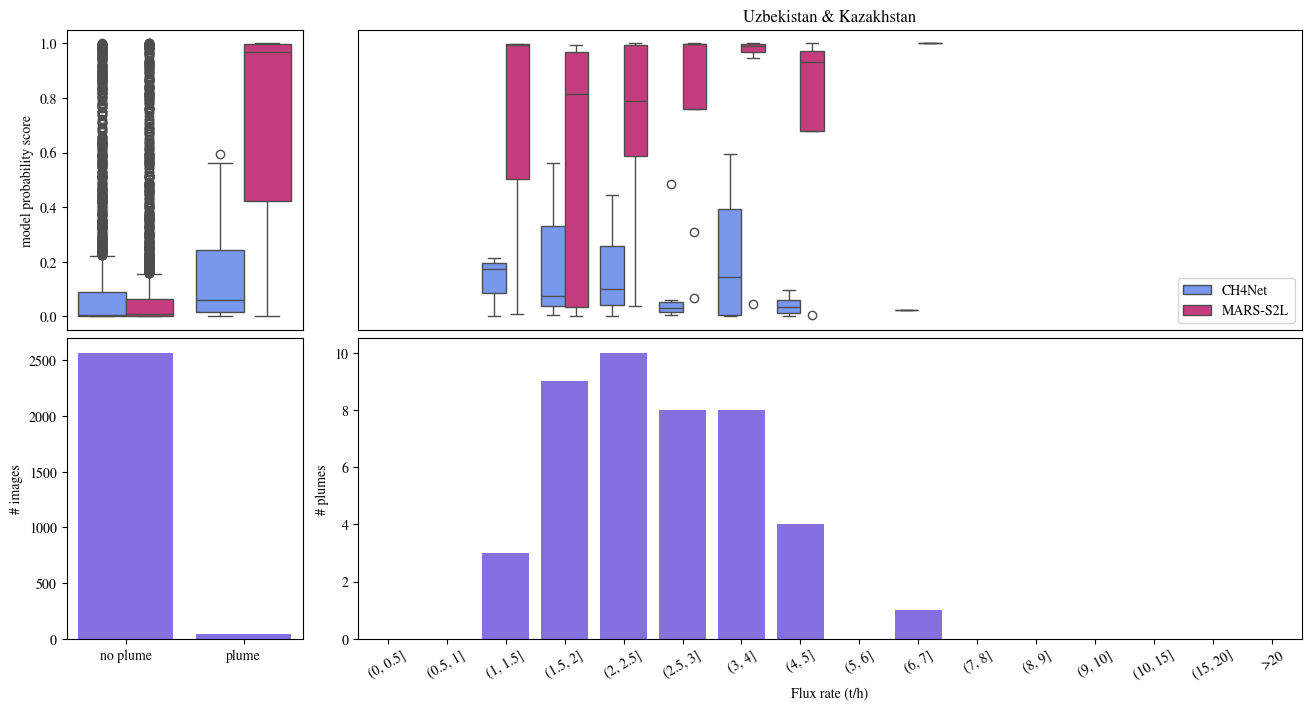

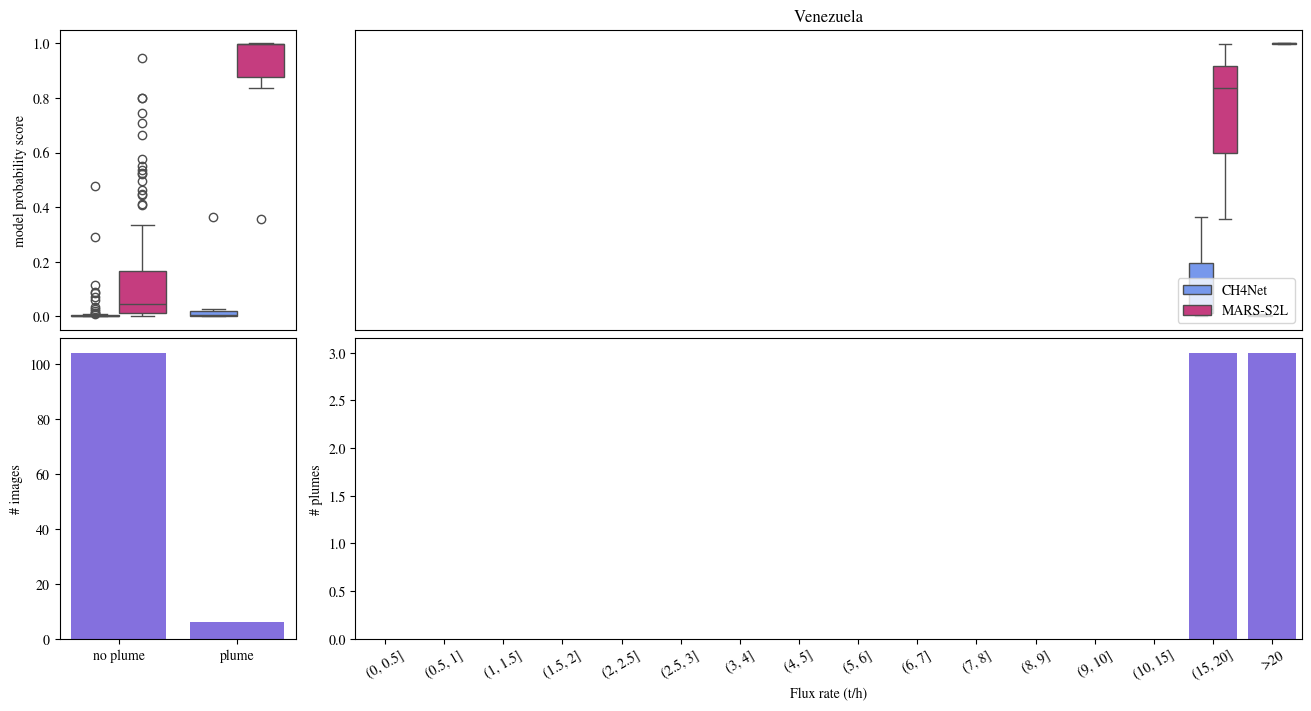

In [36]:
model_names_plot = ["MARS-S2L", "CH4Net"] # "CH4Net",
for case_study, dg in outs_same_period_with_fluxrate.groupby("case_study"): 
    df_plot = dg.loc[dg.model_name.isin(model_names_plot)]
    fig, ax = plot.plot_prob_vs_emission_rate(df_plot)
    ax[1].set_title(case_study)
    plt.show(fig)
    plt.close(fig)

## Histograms predicted probability in the case studies

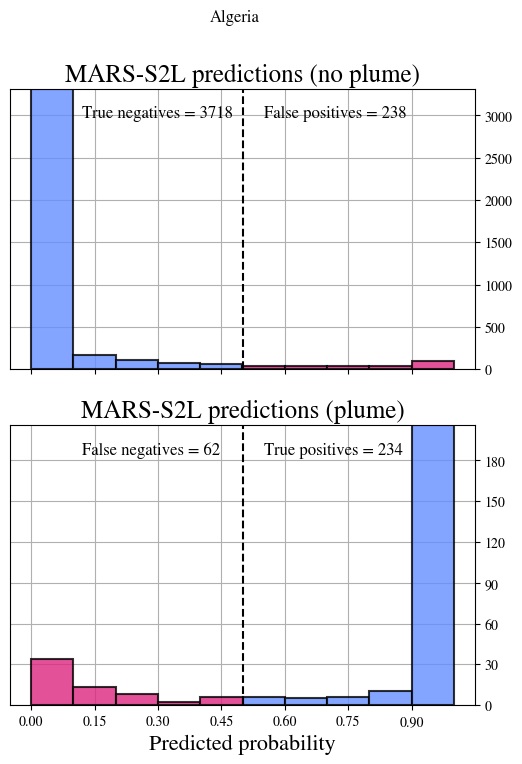

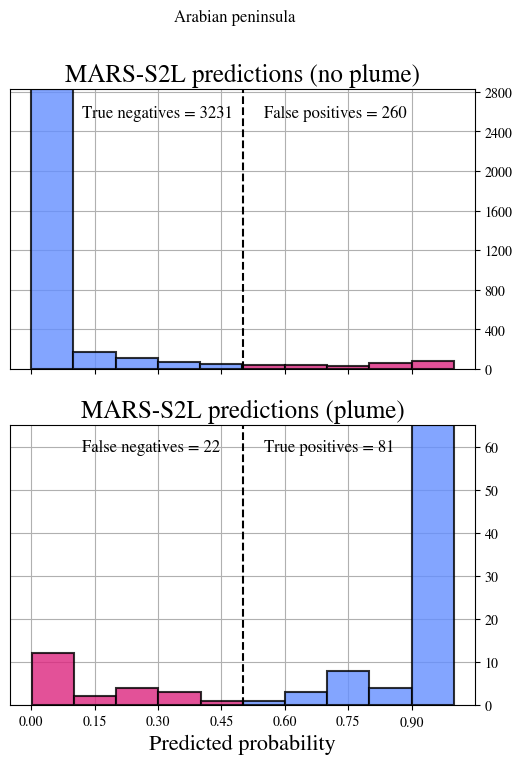

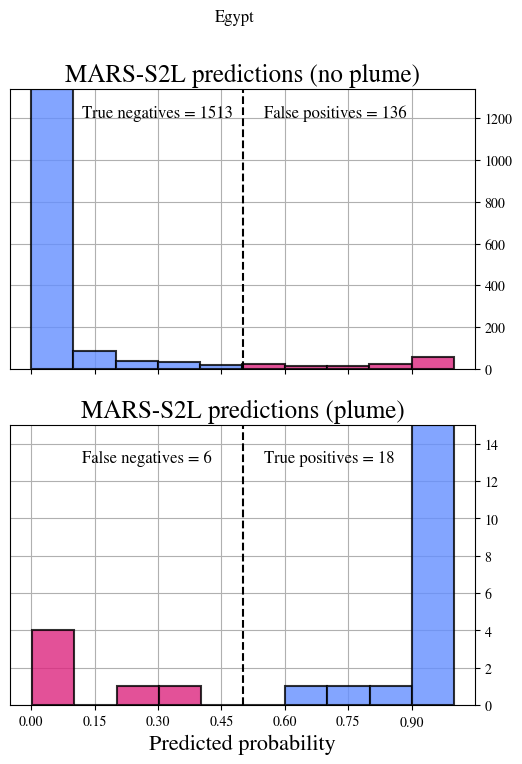

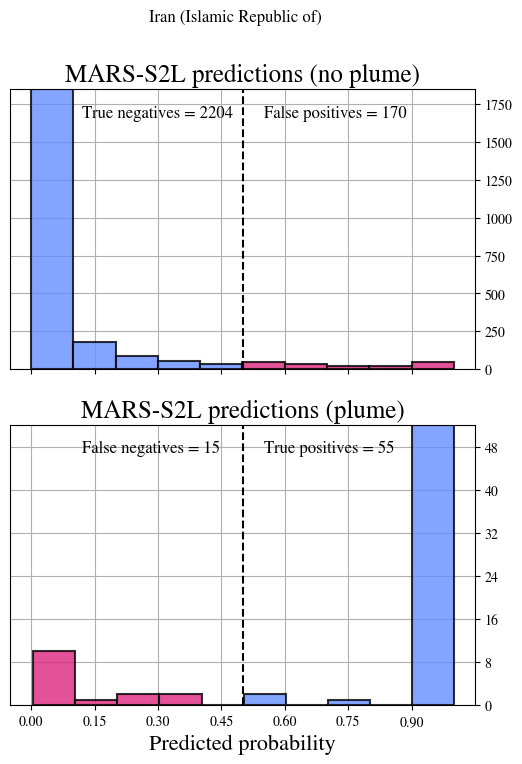

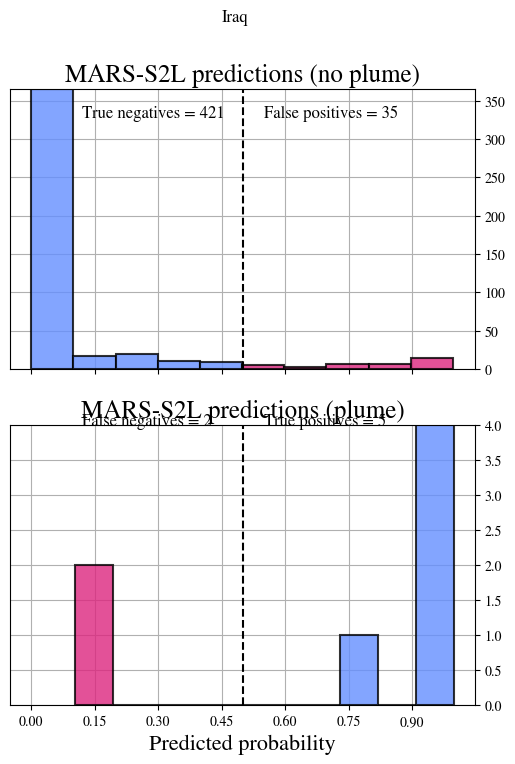

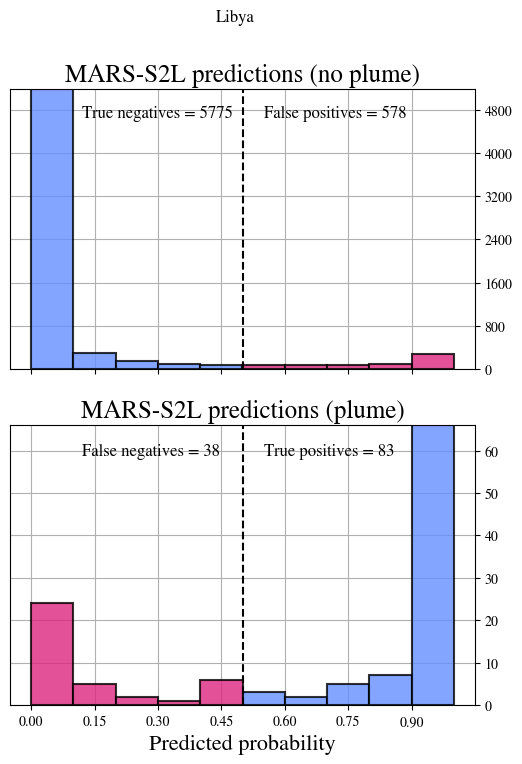

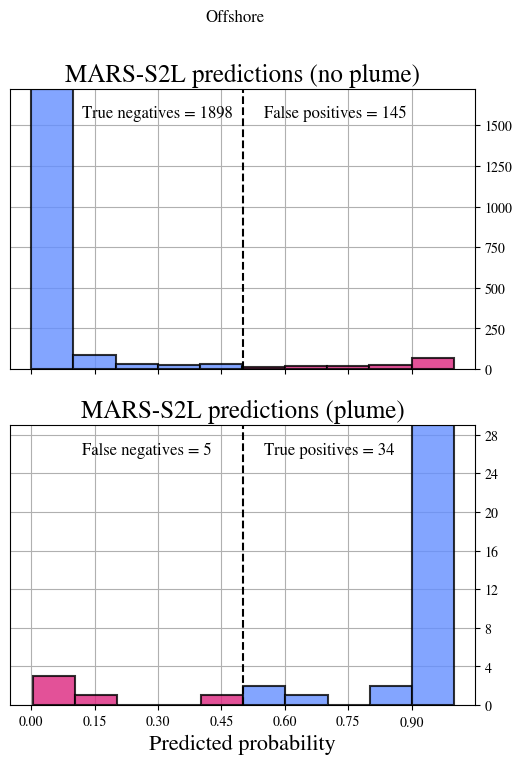

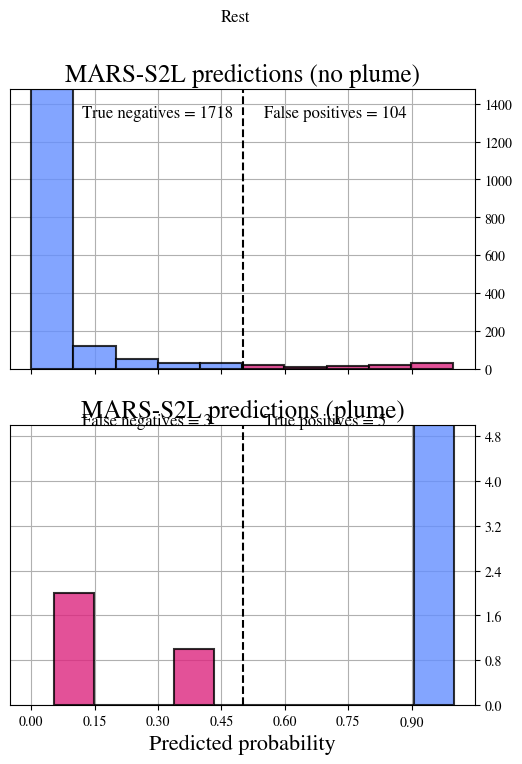

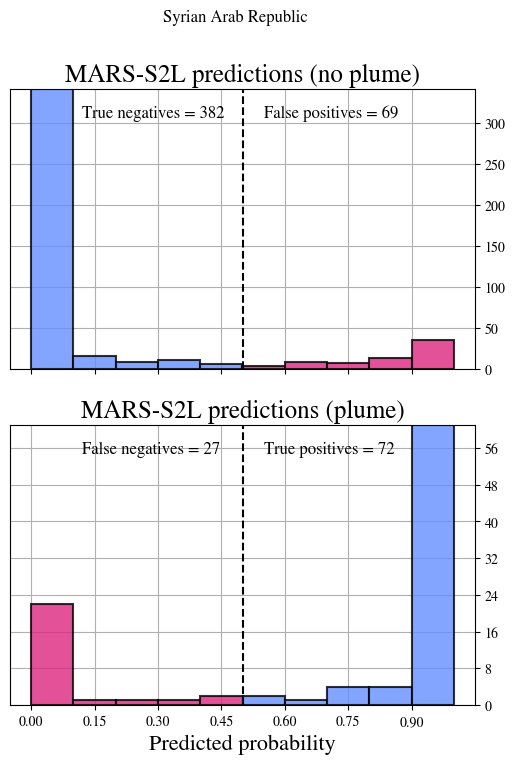

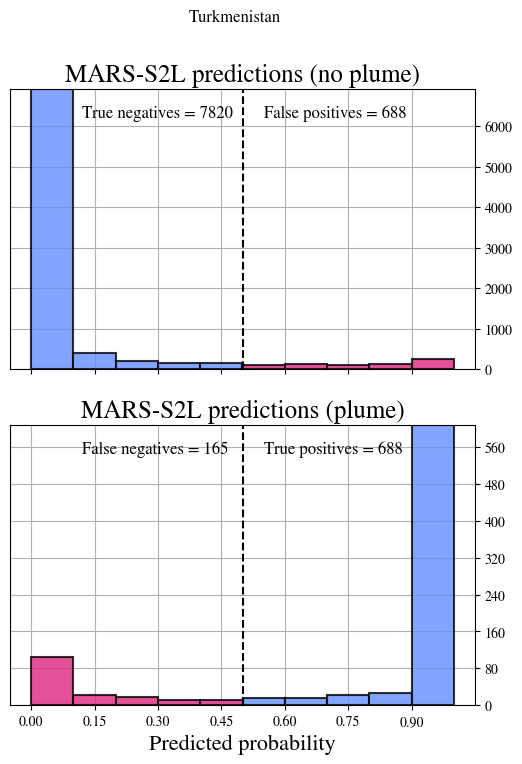

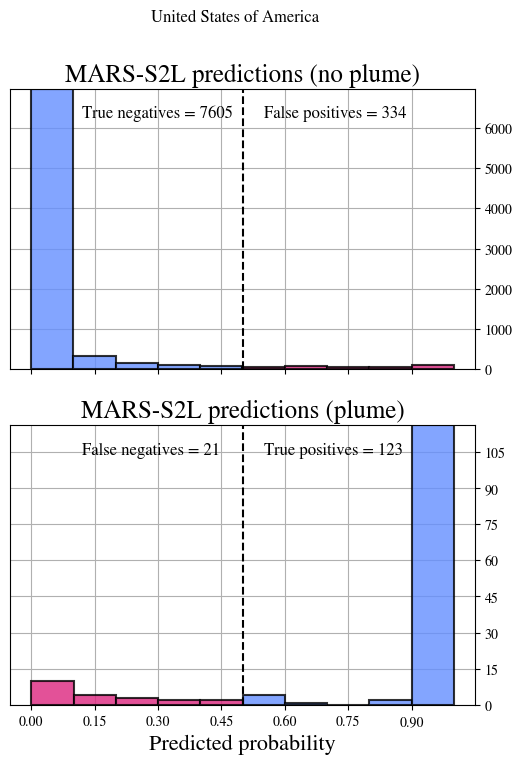

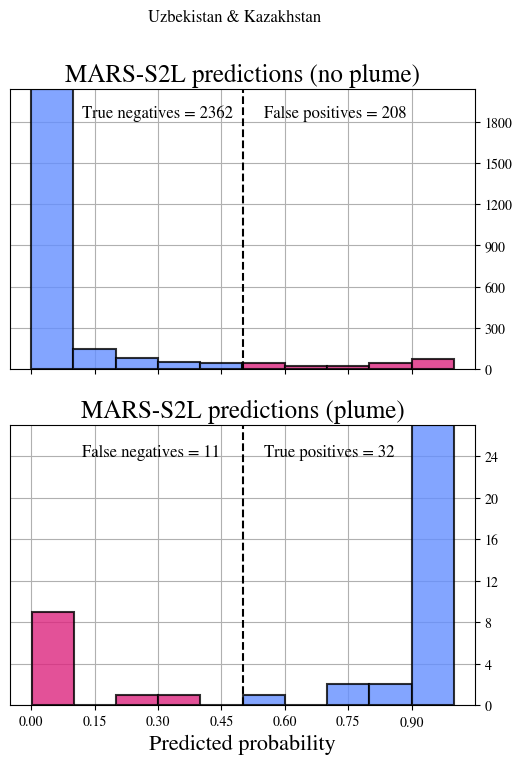

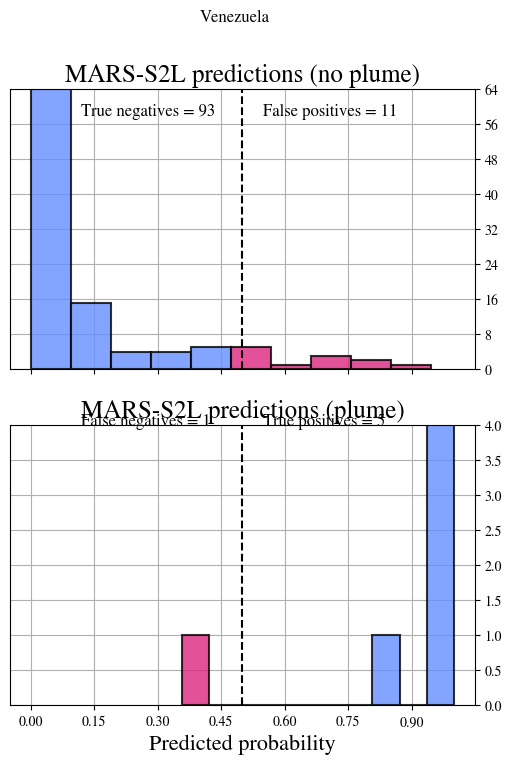

In [37]:
from marss2l import plot
from importlib import reload

reload(plot)


model = "MARS-S2L"
outs_same_period_with_fluxrate["target"] = outs_same_period_with_fluxrate["isplumenum"]

for case_study, dg in outs_same_period_with_fluxrate.groupby("case_study"):  
    if case_study  == "None":
        continue
    
    fig, axs = plt.subplots(2,1, figsize=(6,8), sharex=True, sharey='row')
    dg = outs_same_period_with_fluxrate[(outs_same_period_with_fluxrate.model_name == model) & (outs_same_period_with_fluxrate.case_study == case_study)]
    plot.plot_row(dg, model_name="MARS-S2L", axs=axs)
    plt.suptitle(case_study)
    plt.show()
    plt.close(fig)
    